In [114]:
import os

# results_root = "results"
results_root = "/local/scratch/apj39/bencher-results" # binky

exp_dates = [f for f in os.listdir(results_root)]
exp_dates.sort()

exp_dir = f"{results_root}/{exp_dates[-1]}"

plots_dir = f"{exp_dir}/plots"

os.makedirs(f"{exp_dir}/plots", exist_ok=True)

print(exp_dir)

varied = ["repeat", "bench_type", "bin_name", "delay", "cluster_size", "target_throughput"]

/local/scratch/apj39/bencher-results/2022-05-09T10:54:19.007320885+00:00


In [120]:
import pandas as pd

results_file = f"{exp_dir}/bencher-results.csv"
final_df = pd.read_csv(results_file)

final_df.describe()

/tmp/ipykernel_1651458/3829899073.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  final_df = pd.read_csv(results_file)


,start_ns,end_ns,client,iteration,member_id,raft_term,repeat,cluster_size,target_throughput,delay,delay_variation
count,9.800000e+06,9.800000e+06,9.800000e+06,9.800000e+06,9.800000e+06,9.800000e+06,9800000.0,9800000.0,9.800000e+06,9800000.0,9.800000e+06
mean,1.652098e+18,1.652098e+18,2.550984e+04,7.486151e-01,7.697788e+18,2.629344e+00,0.0,9.0,8.000000e+03,0.0,1.000000e-01
std,3.201654e+12,3.201598e+12,2.203041e+04,1.190501e+00,5.649737e+18,3.092322e+00,0.0,4.0,4.000000e+03,0.0,2.109424e-15
min,1.652094e+18,1.652094e+18,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,3.0,2.000000e+03,0.0,1.000000e-01
25%,1.652095e+18,1.652095e+18,7.150000e+03,0.000000e+00,2.738958e+18,1.000000e+00,0.0,5.0,4.000000e+03,0.0,1.000000e-01
50%,1.652097e+18,1.652097e+18,1.928400e+04,0.000000e+00,7.467176e+18,1.000000e+00,0.0,9.0,8.000000e+03,0.0,1.000000e-01
75%,1.652101e+18,1.652101e+18,3.890900e+04,1.000000e+00,1.216620e+19,4.000000e+00,0.0,13.0,1.200000e+04,0.0,1.000000e-01
max,1.652105e+18,1.652105e+18,9.979400e+04,1.700000e+01,1.834869e+19,1.300000e+01,0.0,15.0,1.400000e+04,0.0,1.000000e-01


In [121]:
# add some useful columns

starts = final_df["start_ns"]
ends = final_df["end_ns"]
latency_ms = (ends-starts) / 1000_000.
final_df["latency_ms"] = latency_ms

final_df.describe()

,start_ns,end_ns,client,iteration,member_id,raft_term,repeat,cluster_size,target_throughput,delay,delay_variation,latency_ms
count,9.800000e+06,9.800000e+06,9.800000e+06,9.800000e+06,9.800000e+06,9.800000e+06,9800000.0,9800000.0,9.800000e+06,9800000.0,9.800000e+06,9.800000e+06
mean,1.652098e+18,1.652098e+18,2.550984e+04,7.486151e-01,7.697788e+18,2.629344e+00,0.0,9.0,8.000000e+03,0.0,1.000000e-01,1.770474e+03
std,3.201654e+12,3.201598e+12,2.203041e+04,1.190501e+00,5.649737e+18,3.092322e+00,0.0,4.0,4.000000e+03,0.0,2.109424e-15,2.994809e+03
min,1.652094e+18,1.652094e+18,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,3.0,2.000000e+03,0.0,1.000000e-01,1.674180e-01
25%,1.652095e+18,1.652095e+18,7.150000e+03,0.000000e+00,2.738958e+18,1.000000e+00,0.0,5.0,4.000000e+03,0.0,1.000000e-01,6.171722e+01
50%,1.652097e+18,1.652097e+18,1.928400e+04,0.000000e+00,7.467176e+18,1.000000e+00,0.0,9.0,8.000000e+03,0.0,1.000000e-01,2.111350e+02
75%,1.652101e+18,1.652101e+18,3.890900e+04,1.000000e+00,1.216620e+19,4.000000e+00,0.0,13.0,1.200000e+04,0.0,1.000000e-01,2.266799e+03
max,1.652105e+18,1.652105e+18,9.979400e+04,1.700000e+01,1.834869e+19,1.300000e+01,0.0,15.0,1.400000e+04,0.0,1.000000e-01,2.452870e+04


In [122]:
data = final_df

min_data = data.groupby(varied)["start_ns"].min()
min_data = min_data.rename("min_start")
display(min_data)

data = data.merge(min_data, on=varied, suffixes=(None, None))

data["start_relative"] = data["start_ns"] - data["min_start"]

final_df = data
final_df

repeat  bench_type  bin_name        delay  cluster_size  target_throughput
0       PutRange    etcd            0      3             2000                 1652093668488810758
                                                         4000                 1652093830806048564
                                                         6000                 1652093944668171455
                                                         8000                 1652094043081740242
                                                         10000                1652094132636977695
                                                                                     ...         
                    mergeable-etcd  0      15            6000                 1652103192092172638
                                                         8000                 1652103530611908635
                                                         10000                1652103868371348085
                                           

,start_ns,end_ns,key,error,client,iteration,member_id,raft_term,repeat,cluster_size,bench_type,target_throughput,bin_name,delay,delay_variation,latency_ms,min_start,start_relative
0,1652093701600098635,1652093701602107990,bench-66225,NaN,10037,0,7.957497e+18,2,0,3,PutRange,2000,etcd,0,0.1,2.009355,1652093668488810758,33111287877
1,1652093701602121754,1652093701662136940,bench-66229,NaN,10037,1,1.216620e+19,2,0,3,PutRange,2000,etcd,0,0.1,60.015186,1652093668488810758,33113310996
2,1652093701601775750,1652093701662159648,bench-66228,NaN,34625,0,1.216620e+19,2,0,3,PutRange,2000,etcd,0,0.1,60.383898,1652093668488810758,33112964992
3,1652093690394093671,1652093690556758228,bench-43814,NaN,22909,0,1.216620e+19,2,0,3,PutRange,2000,etcd,0,0.1,162.664557,1652093668488810758,21905282913
4,1652093701616744667,1652093701663364979,bench-66258,NaN,34637,0,1.216620e+19,2,0,3,PutRange,2000,etcd,0,0.1,46.620312,1652093668488810758,33127933909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9799995,1652104578076972145,1652104578677187483,bench-99803,NaN,36035,1,1.763392e+19,1,0,15,PutRange,14000,mergeable-etcd,0,0.1,600.215338,1652104560532614573,17544357572
9799996,1652104578043303476,1652104578677406702,bench-99573,NaN,91091,0,1.763392e+19,1,0,15,PutRange,14000,mergeable-etcd,0,0.1,634.103226,1652104560532614573,17510688903
9799997,1652104578043422499,1652104578685409329,bench-99574,NaN,91092,0,1.763392e+19,1,0,15,PutRange,14000,mergeable-etcd,0,0.1,641.986830,1652104560532614573,17510807926
9799998,1652104563230992324,1652104563335036815,bench-14720,NaN,13150,0,1.586390e+19,1,0,15,PutRange,14000,mergeable-etcd,0,0.1,104.044491,1652104560532614573,2698377751


In [123]:
final_df.dtypes

start_ns               int64
end_ns                 int64
key                   object
error                 object
client                 int64
iteration              int64
member_id            float64
raft_term              int64
repeat                 int64
cluster_size           int64
bench_type            object
target_throughput      int64
bin_name              object
delay                  int64
delay_variation      float64
latency_ms           float64
min_start              int64
start_relative         int64
dtype: object

In [124]:
# optimise dtypes for space

categoricals = ["key", "bench_type", "bin_name", "error"]
for cat in categoricals:
    final_df[cat] = final_df[cat].astype("category")

In [125]:
final_df.dtypes

start_ns                int64
end_ns                  int64
key                  category
error                category
client                  int64
iteration               int64
member_id             float64
raft_term               int64
repeat                  int64
cluster_size            int64
bench_type           category
target_throughput       int64
bin_name             category
delay                   int64
delay_variation       float64
latency_ms            float64
min_start               int64
start_relative          int64
dtype: object

In [126]:
final_df.head()

,start_ns,end_ns,key,error,client,iteration,member_id,raft_term,repeat,cluster_size,bench_type,target_throughput,bin_name,delay,delay_variation,latency_ms,min_start,start_relative
0,1652093701600098635,1652093701602107990,bench-66225,NaN,10037,0,7.957497e+18,2,0,3,PutRange,2000,etcd,0,0.1,2.009355,1652093668488810758,33111287877
1,1652093701602121754,1652093701662136940,bench-66229,NaN,10037,1,1.216620e+19,2,0,3,PutRange,2000,etcd,0,0.1,60.015186,1652093668488810758,33113310996
2,1652093701601775750,1652093701662159648,bench-66228,NaN,34625,0,1.216620e+19,2,0,3,PutRange,2000,etcd,0,0.1,60.383898,1652093668488810758,33112964992
3,1652093690394093671,1652093690556758228,bench-43814,NaN,22909,0,1.216620e+19,2,0,3,PutRange,2000,etcd,0,0.1,162.664557,1652093668488810758,21905282913
4,1652093701616744667,1652093701663364979,bench-66258,NaN,34637,0,1.216620e+19,2,0,3,PutRange,2000,etcd,0,0.1,46.620312,1652093668488810758,33127933909


In [127]:
import seaborn as sns

def plot_scatter(bench_type:str):
    sns.set_palette("colorblind")
    sns.set_style("ticks")
    
    data = final_df[final_df.bench_type == bench_type]
    if not data.empty:
        ax = sns.relplot(kind = "scatter", data = data, x="start_relative", y = "latency_ms", row="cluster_size", col="bin_name", hue="target_throughput")

In [128]:
# plot_scatter("PutSingle")

In [129]:
# plot_scatter("PutRange")

In [130]:
# plot_scatter("PutRandom")

In [131]:
import seaborn as sns

def plot_box(bench_type):
    sns.set_palette("colorblind")
    sns.set_style("ticks")
    
    data = final_df
    data = data[data.cluster_size > 1]
    data = data[data.bench_type == bench_type]
    display(data)
    if not data.empty:
        ax = sns.catplot(kind="box", data=data, x="bin_name", y = "latency_ms", row="cluster_size", col="target_throughput")
        ax.savefig(f"{plots_dir}/box-{bench_type}.png")
        ax.savefig(f"{plots_dir}/box-{bench_type}.svg")
        ax.savefig(f"{plots_dir}/box-{bench_type}.pdf")

In [132]:
plot_box("PutSingle")

,start_ns,end_ns,key,error,client,iteration,member_id,raft_term,repeat,cluster_size,bench_type,target_throughput,bin_name,delay,delay_variation,latency_ms,min_start,start_relative


,start_ns,end_ns,key,error,client,iteration,member_id,raft_term,repeat,cluster_size,bench_type,target_throughput,bin_name,delay,delay_variation,latency_ms,min_start,start_relative
0,1652093701600098635,1652093701602107990,bench-66225,NaN,10037,0,7.957497e+18,2,0,3,PutRange,2000,etcd,0,0.1,2.009355,1652093668488810758,33111287877
1,1652093701602121754,1652093701662136940,bench-66229,NaN,10037,1,1.216620e+19,2,0,3,PutRange,2000,etcd,0,0.1,60.015186,1652093668488810758,33113310996
2,1652093701601775750,1652093701662159648,bench-66228,NaN,34625,0,1.216620e+19,2,0,3,PutRange,2000,etcd,0,0.1,60.383898,1652093668488810758,33112964992
3,1652093690394093671,1652093690556758228,bench-43814,NaN,22909,0,1.216620e+19,2,0,3,PutRange,2000,etcd,0,0.1,162.664557,1652093668488810758,21905282913
4,1652093701616744667,1652093701663364979,bench-66258,NaN,34637,0,1.216620e+19,2,0,3,PutRange,2000,etcd,0,0.1,46.620312,1652093668488810758,33127933909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9799995,1652104578076972145,1652104578677187483,bench-99803,NaN,36035,1,1.763392e+19,1,0,15,PutRange,14000,mergeable-etcd,0,0.1,600.215338,1652104560532614573,17544357572
9799996,1652104578043303476,1652104578677406702,bench-99573,NaN,91091,0,1.763392e+19,1,0,15,PutRange,14000,mergeable-etcd,0,0.1,634.103226,1652104560532614573,17510688903
9799997,1652104578043422499,1652104578685409329,bench-99574,NaN,91092,0,1.763392e+19,1,0,15,PutRange,14000,mergeable-etcd,0,0.1,641.986830,1652104560532614573,17510807926
9799998,1652104563230992324,1652104563335036815,bench-14720,NaN,13150,0,1.586390e+19,1,0,15,PutRange,14000,mergeable-etcd,0,0.1,104.044491,1652104560532614573,2698377751


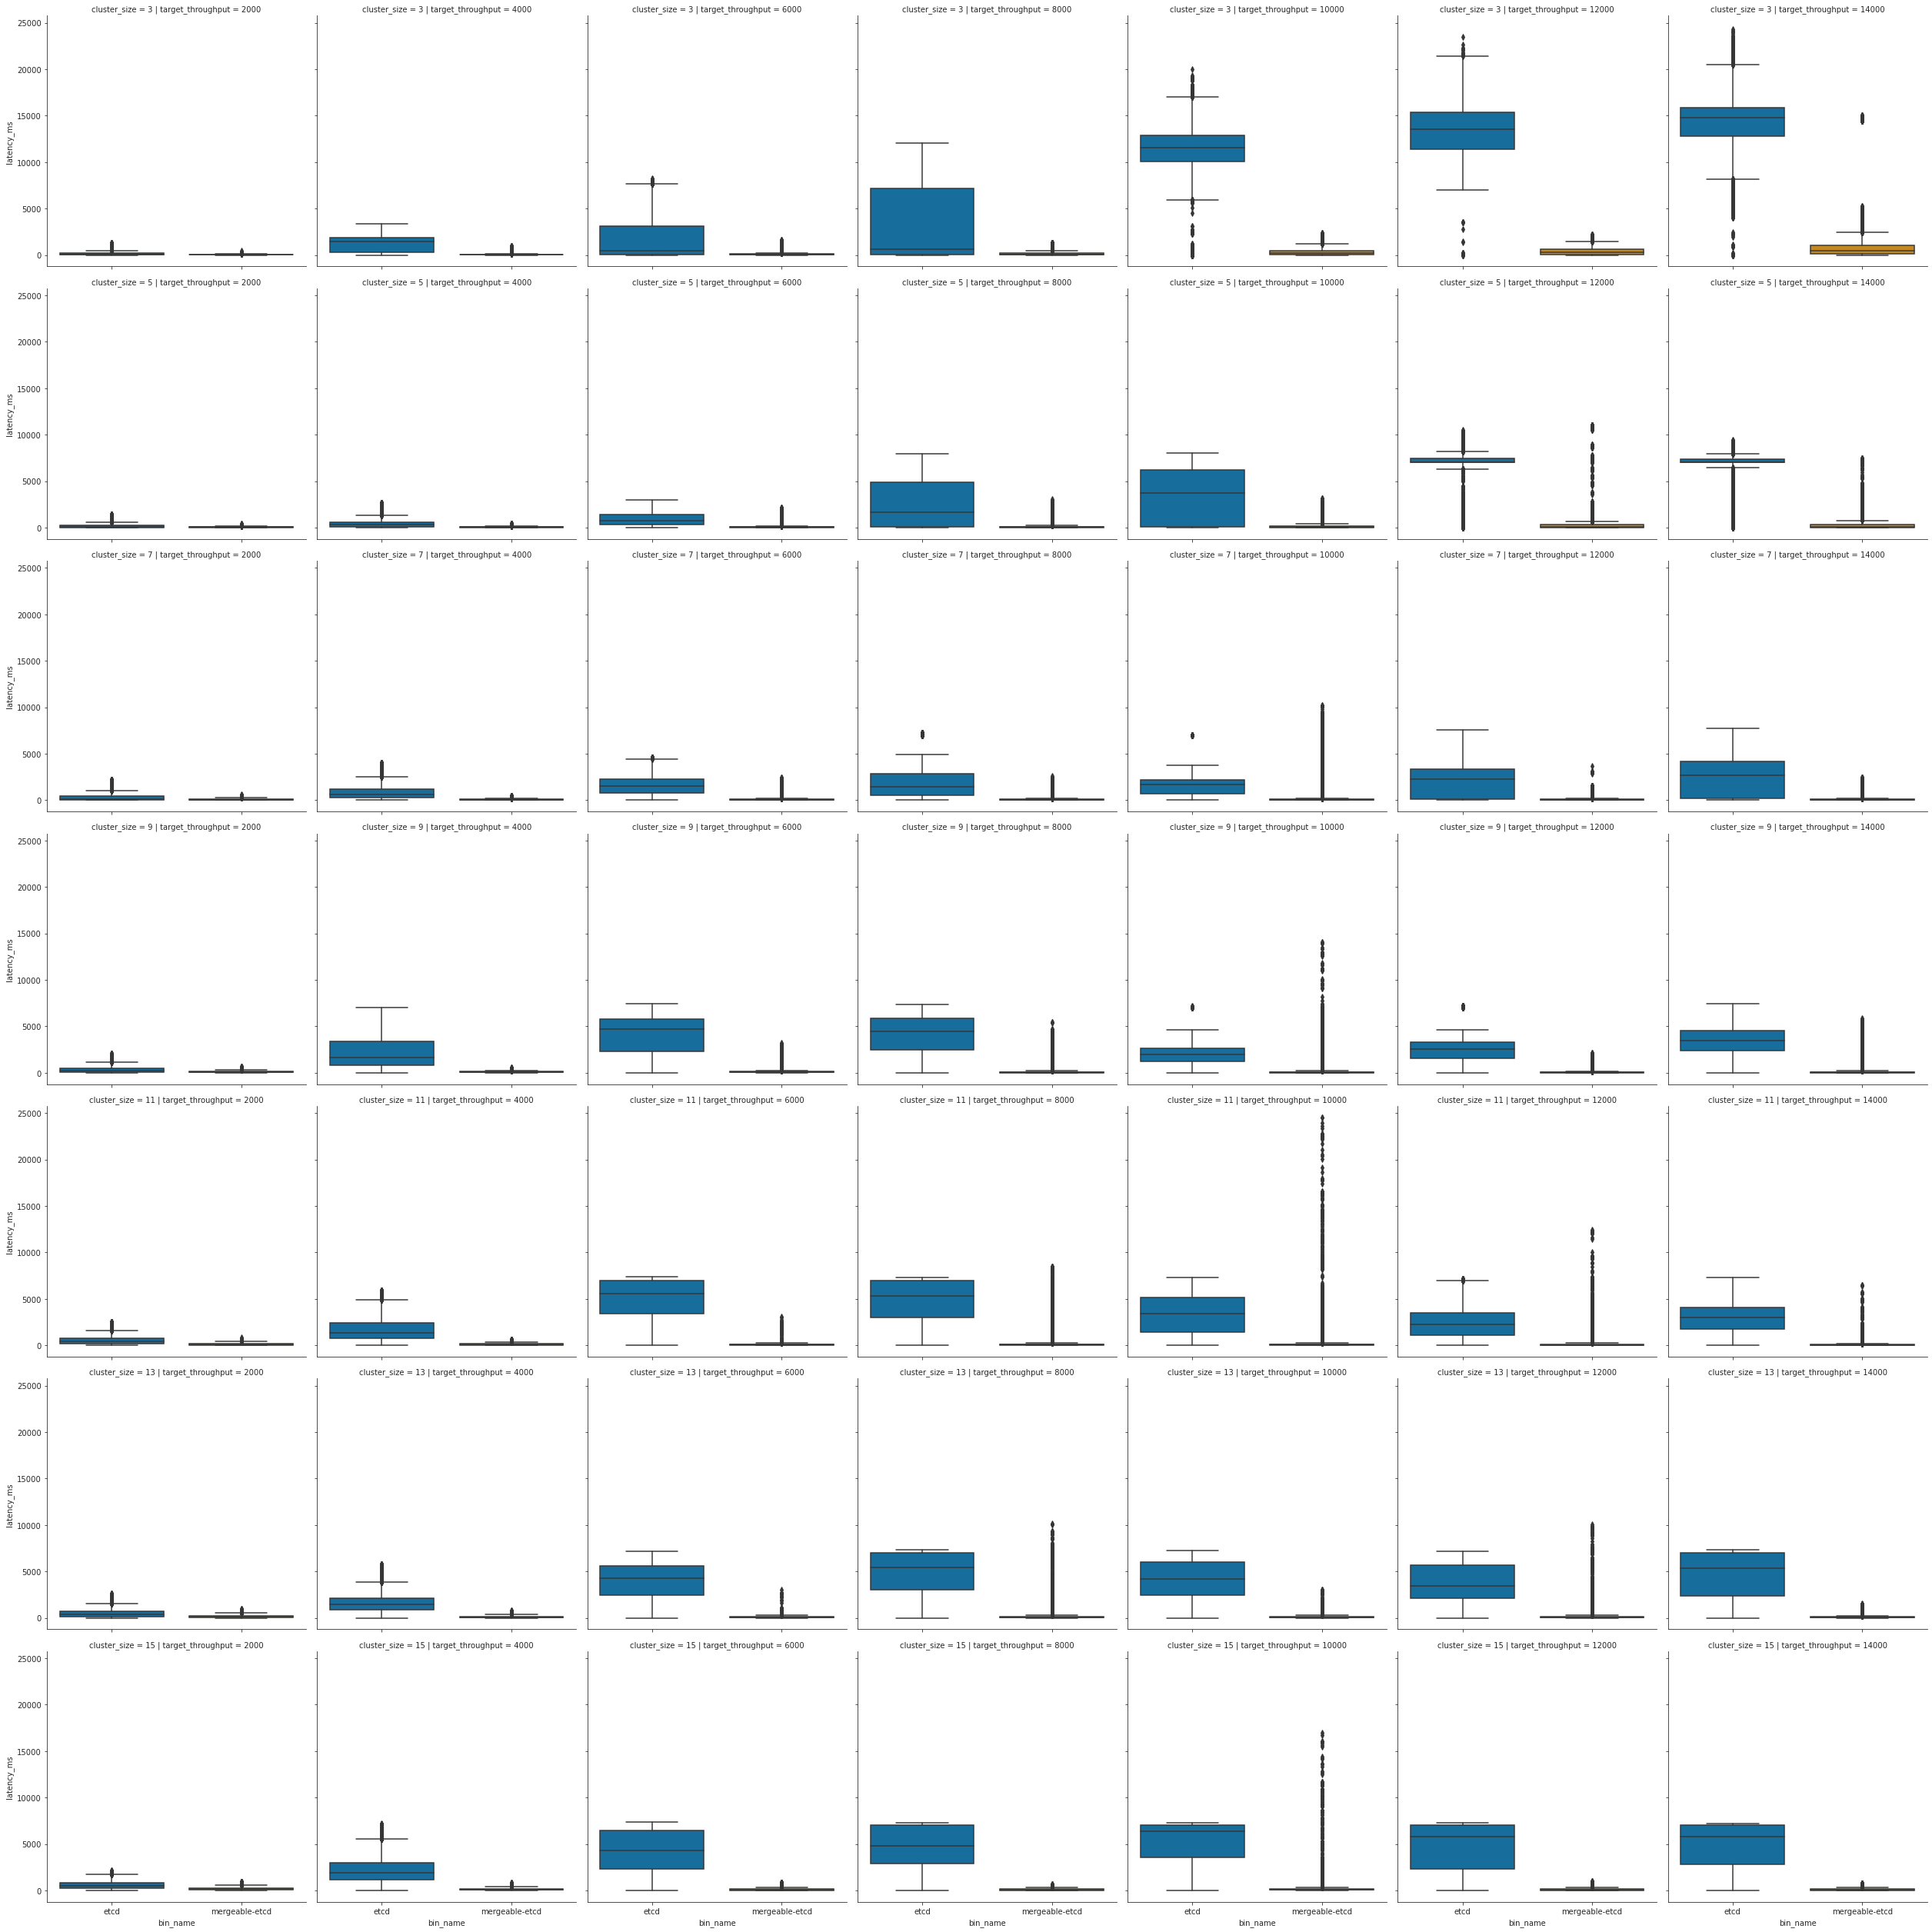

In [133]:
plot_box("PutRange")

In [134]:
plot_box("PutRandom")

,start_ns,end_ns,key,error,client,iteration,member_id,raft_term,repeat,cluster_size,bench_type,target_throughput,bin_name,delay,delay_variation,latency_ms,min_start,start_relative


In [135]:
import seaborn as sns

def plot_cdf(bench_type):
    sns.set_palette("colorblind")
    sns.set_style("ticks")
    
    data = final_df
    data = data[data.cluster_size > 1]
    data = data[pd.isna(data.error)]
    data = data[(data.bench_type == bench_type)]
    display(data)
    if not data.empty:
        ax = sns.displot(kind="ecdf", data=data, x="latency_ms", hue="bin_name", col="target_throughput", row="cluster_size", stat="count")
        ax.set(xlabel="Latency (ms)")
        ax.savefig(f"{plots_dir}/cdf-{bench_type}.png")
        ax.savefig(f"{plots_dir}/cdf-{bench_type}.svg")
        ax.savefig(f"{plots_dir}/cdf-{bench_type}.pdf")

In [136]:
plot_cdf("PutSingle")

,start_ns,end_ns,key,error,client,iteration,member_id,raft_term,repeat,cluster_size,bench_type,target_throughput,bin_name,delay,delay_variation,latency_ms,min_start,start_relative


,start_ns,end_ns,key,error,client,iteration,member_id,raft_term,repeat,cluster_size,bench_type,target_throughput,bin_name,delay,delay_variation,latency_ms,min_start,start_relative
0,1652093701600098635,1652093701602107990,bench-66225,NaN,10037,0,7.957497e+18,2,0,3,PutRange,2000,etcd,0,0.1,2.009355,1652093668488810758,33111287877
1,1652093701602121754,1652093701662136940,bench-66229,NaN,10037,1,1.216620e+19,2,0,3,PutRange,2000,etcd,0,0.1,60.015186,1652093668488810758,33113310996
2,1652093701601775750,1652093701662159648,bench-66228,NaN,34625,0,1.216620e+19,2,0,3,PutRange,2000,etcd,0,0.1,60.383898,1652093668488810758,33112964992
3,1652093690394093671,1652093690556758228,bench-43814,NaN,22909,0,1.216620e+19,2,0,3,PutRange,2000,etcd,0,0.1,162.664557,1652093668488810758,21905282913
4,1652093701616744667,1652093701663364979,bench-66258,NaN,34637,0,1.216620e+19,2,0,3,PutRange,2000,etcd,0,0.1,46.620312,1652093668488810758,33127933909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9799995,1652104578076972145,1652104578677187483,bench-99803,NaN,36035,1,1.763392e+19,1,0,15,PutRange,14000,mergeable-etcd,0,0.1,600.215338,1652104560532614573,17544357572
9799996,1652104578043303476,1652104578677406702,bench-99573,NaN,91091,0,1.763392e+19,1,0,15,PutRange,14000,mergeable-etcd,0,0.1,634.103226,1652104560532614573,17510688903
9799997,1652104578043422499,1652104578685409329,bench-99574,NaN,91092,0,1.763392e+19,1,0,15,PutRange,14000,mergeable-etcd,0,0.1,641.986830,1652104560532614573,17510807926
9799998,1652104563230992324,1652104563335036815,bench-14720,NaN,13150,0,1.586390e+19,1,0,15,PutRange,14000,mergeable-etcd,0,0.1,104.044491,1652104560532614573,2698377751


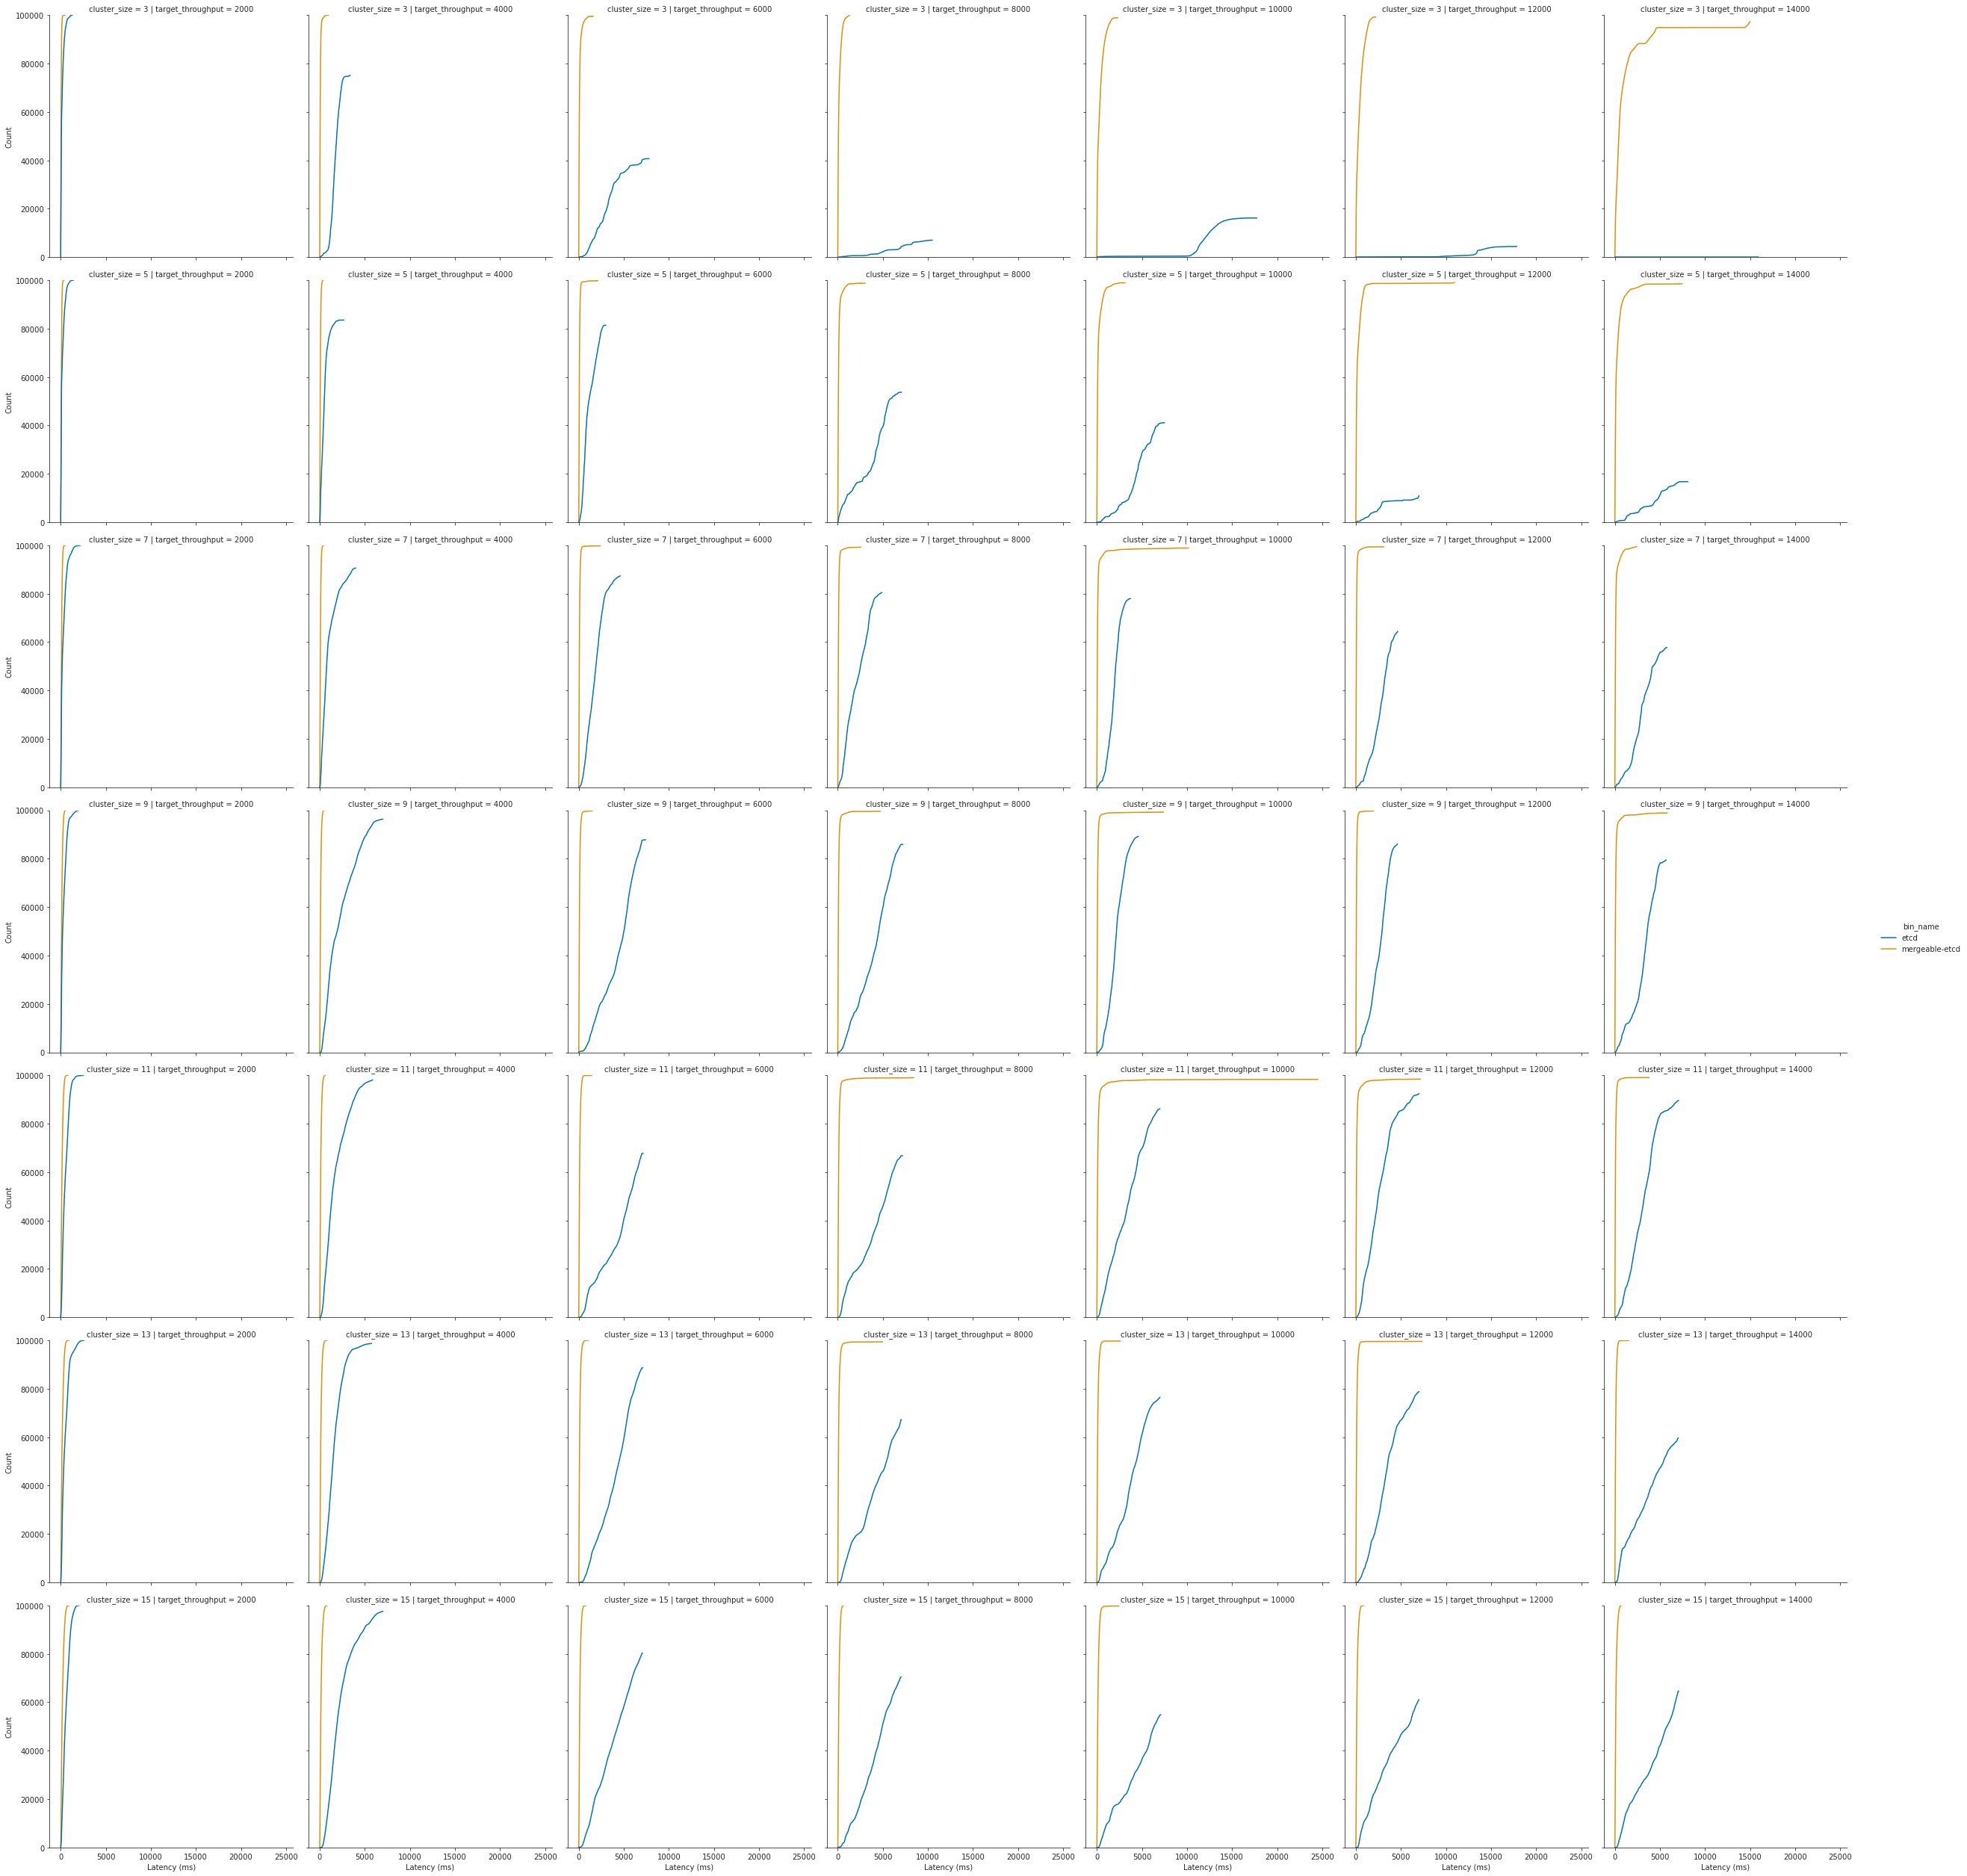

In [137]:
plot_cdf("PutRange")

In [138]:
plot_cdf("PutRandom")

,start_ns,end_ns,key,error,client,iteration,member_id,raft_term,repeat,cluster_size,bench_type,target_throughput,bin_name,delay,delay_variation,latency_ms,min_start,start_relative


,start_ns,end_ns,key,error,client,iteration,member_id,raft_term,repeat,cluster_size,bench_type,target_throughput,bin_name,delay,delay_variation,latency_ms,min_start,start_relative
800094,1652094132786681474,1652094132972037093,bench-178,NaN,164,0,2.840119e+18,2,0,3,PutRange,10000,etcd,0,0.1,185.355619,1652094132636977695,149703779
800228,1652094132643752794,1652094132700926896,bench-15,NaN,15,0,2.840119e+18,2,0,3,PutRange,10000,etcd,0,0.1,57.174102,1652094132636977695,6775099
800229,1652094132700939746,1652094132776189765,bench-51,NaN,15,1,2.840119e+18,2,0,3,PutRange,10000,etcd,0,0.1,75.250019,1652094132636977695,63962051
800230,1652094132776192098,1652094132873519038,bench-147,NaN,15,2,2.840119e+18,2,0,3,PutRange,10000,etcd,0,0.1,97.326940,1652094132636977695,139214403
800264,1652094132846995310,1652094133165940305,bench-774,NaN,683,0,2.840119e+18,2,0,3,PutRange,10000,etcd,0,0.1,318.944995,1652094132636977695,210017615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9399977,1652103875146629414,1652103875341897810,bench-36337,NaN,12552,0,1.592096e+19,1,0,15,PutRange,10000,mergeable-etcd,0,0.1,195.268396,1652103868371348085,6775281329
9399983,1652103874914066216,1652103874964303252,bench-35170,NaN,32119,0,4.760754e+18,1,0,15,PutRange,10000,mergeable-etcd,0,0.1,50.237036,1652103868371348085,6542718131
9399992,1652103869013667107,1652103869028648947,bench-2737,NaN,1184,0,1.100295e+19,1,0,15,PutRange,10000,mergeable-etcd,0,0.1,14.981840,1652103868371348085,642319022
9399993,1652103875043373108,1652103875114775654,bench-35842,NaN,1184,1,4.024080e+18,1,0,15,PutRange,10000,mergeable-etcd,0,0.1,71.402546,1652103868371348085,6672025023


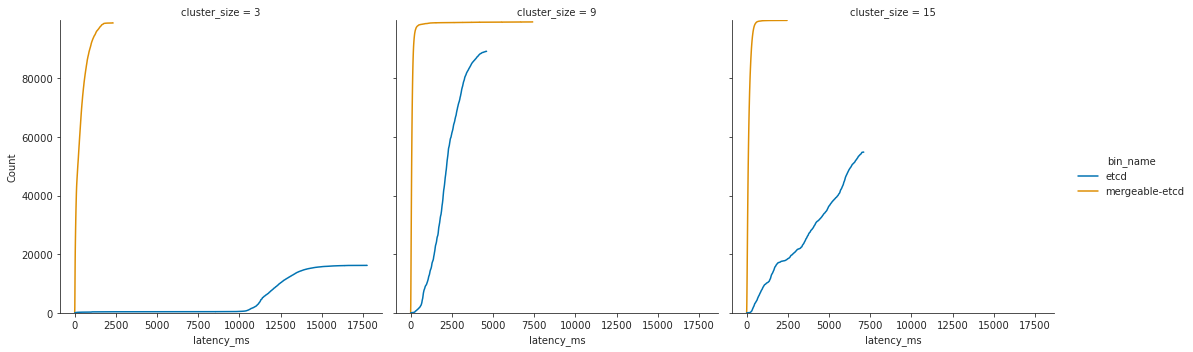

In [139]:
bench_type = "PutRange"

data = final_df
data = data[(data.cluster_size == 3) | (data.cluster_size == 9) | (data.cluster_size == 15)]
data = data[pd.isna(data.error)]
data = data[(data.bench_type == bench_type)]
data = data[data.target_throughput == 10000]
display(data)
if not data.empty:
    ax = sns.displot(kind="ecdf", data=data, x="latency_ms", hue="bin_name", col="cluster_size", stat="count")
    ax.savefig(f"{plots_dir}/cdf-{bench_type}.png")
    ax.savefig(f"{plots_dir}/cdf-{bench_type}.svg")
    ax.savefig(f"{plots_dir}/cdf-{bench_type}.pdf")

In [140]:
final_df[pd.notna(final_df.error)].describe()

,start_ns,end_ns,client,iteration,member_id,raft_term,repeat,cluster_size,target_throughput,delay,delay_variation,latency_ms,min_start,start_relative
count,1.408995e+06,1.408995e+06,1.408995e+06,1.408995e+06,1408995.0,1408995.0,1408995.0,1.408995e+06,1.408995e+06,1408995.0,1.408995e+06,1.408995e+06,1.408995e+06,1.408995e+06
mean,1.652097e+18,1.652097e+18,4.018306e+04,4.279504e-01,0.0,0.0,0.0,7.180783e+00,1.027932e+04,0.0,1.000000e-01,6.017930e+03,1.652097e+18,6.884022e+09
std,3.405450e+12,3.405354e+12,2.463743e+04,7.890360e-01,0.0,0.0,0.0,4.320355e+00,2.973565e+03,0.0,1.526557e-16,4.851002e+03,3.404594e+12,3.903613e+09
min,1.652094e+18,1.652094e+18,1.000000e+00,0.000000e+00,0.0,0.0,0.0,3.000000e+00,4.000000e+03,0.0,1.000000e-01,1.674180e-01,1.652094e+18,6.164788e+07
25%,1.652094e+18,1.652094e+18,1.913900e+04,0.000000e+00,0.0,0.0,0.0,3.000000e+00,8.000000e+03,0.0,1.000000e-01,1.076124e+02,1.652094e+18,4.308640e+09
50%,1.652095e+18,1.652095e+18,3.860000e+04,0.000000e+00,0.0,0.0,0.0,5.000000e+00,1.000000e+04,0.0,1.000000e-01,7.000915e+03,1.652095e+18,6.563969e+09
75%,1.652099e+18,1.652099e+18,5.965000e+04,1.000000e+00,0.0,0.0,0.0,1.100000e+01,1.200000e+04,0.0,1.000000e-01,7.392979e+03,1.652099e+18,8.645826e+09
max,1.652104e+18,1.652104e+18,9.979400e+04,1.300000e+01,0.0,0.0,0.0,1.500000e+01,1.400000e+04,0.0,1.000000e-01,2.431845e+04,1.652104e+18,2.500601e+10


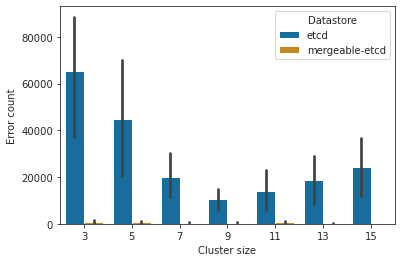

In [141]:
import seaborn as sns

# error count bar chart

sns.set_palette("colorblind")
sns.set_style("ticks")

data = final_df.groupby(varied).count()
data.reset_index(inplace=True)
data = data.rename(columns = {"bin_name": "Datastore"})

ax = sns.barplot(data=data, x="cluster_size", y="error", hue="Datastore")
ax.set(xlabel="Cluster size", ylabel="Error count")

fig = ax.get_figure()
fig.savefig(f"{plots_dir}/errors-bar.png")
fig.savefig(f"{plots_dir}/errors-bar.svg")
fig.savefig(f"{plots_dir}/errors-bar.pdf")

,start_ns,end_ns,key,error,client,iteration,member_id,raft_term,repeat,cluster_size,bench_type,target_throughput,Datastore,delay,delay_variation,latency_ms,min_start,start_relative
800000,1652094132985001212,1652094142576834648,NaN,etcdserver: request timed out,2786,0,0.000000e+00,0,0,3,PutRange,10000,etcd,0,0.1,9591.833436,1652094132636977695,348023517
800001,1652094133680593677,1652094142577053880,NaN,etcdserver: request timed out,10083,0,0.000000e+00,0,0,3,PutRange,10000,etcd,0,0.1,8896.460203,1652094132636977695,1043615982
800002,1652094133486929610,1652094142577067898,NaN,etcdserver: request timed out,8226,0,0.000000e+00,0,0,3,PutRange,10000,etcd,0,0.1,9090.138288,1652094132636977695,849951915
800003,1652094134846091706,1652094142566541030,NaN,etcdserver: request timed out,21738,0,0.000000e+00,0,0,3,PutRange,10000,etcd,0,0.1,7720.449324,1652094132636977695,2209114011
800004,1652094134290097533,1652094142577107622,NaN,etcdserver: request timed out,16142,0,0.000000e+00,0,0,3,PutRange,10000,etcd,0,0.1,8287.010089,1652094132636977695,1653119838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9399995,1652103885991394621,1652103902085654397,NaN,Timeout expired,85688,0,0.000000e+00,0,0,15,PutRange,10000,mergeable-etcd,0,0.1,16094.259776,1652103868371348085,17620046536
9399996,1652103885991611872,1652103902085814278,NaN,Timeout expired,85690,0,0.000000e+00,0,0,15,PutRange,10000,mergeable-etcd,0,0.1,16094.202406,1652103868371348085,17620263787
9399997,1652103874899264155,1652103874955373223,bench-35112,NaN,32003,0,3.901678e+18,1,0,15,PutRange,10000,mergeable-etcd,0,0.1,56.109068,1652103868371348085,6527916070
9399998,1652103885995297274,1652103902739818986,NaN,Timeout expired,32003,1,0.000000e+00,0,0,15,PutRange,10000,mergeable-etcd,0,0.1,16744.521712,1652103868371348085,17623949189


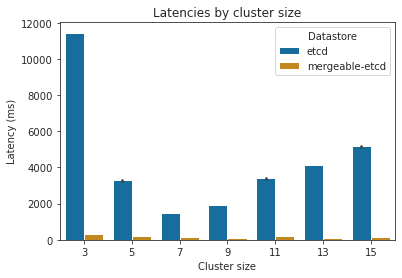

In [142]:
import seaborn as sns

sns.set_palette("colorblind")
sns.set_style("ticks")

data = final_df

data = data[data.cluster_size > 1]

data = data[data.target_throughput == 10000]

data = data.rename(columns = {"bin_name": "Datastore"})

display(data)

# ax = sns.lineplot(data=data, x="cluster_size", y="latency_ms", hue="bin_name", markers=True)

ax = sns.barplot(data=data, x="cluster_size", y="latency_ms", hue="Datastore")
ax.set(title="Latencies by cluster size", xlabel="Cluster size", ylabel="Latency (ms)")

fig = ax.get_figure()
fig.savefig(f"{plots_dir}/latencies-bar.png")
fig.savefig(f"{plots_dir}/latencies-bar.svg")
fig.savefig(f"{plots_dir}/latencies-bar.pdf")

start_relative  \
repeat bench_type bin_name       delay cluster_size target_throughput                   
0      PutRange   etcd           0     3            2000                  2000.030488   
                                                    4000                  3999.992924   
                                                    6000                  5986.330168   
                                                    8000                  8000.876831   
                                                    10000                 9999.698325   
...                                                                               ...   
                  mergeable-etcd 0     15           6000                  5518.733037   
                                                    8000                  5455.360952   
                                                    10000                 5292.642028   
                                                    12000                 5417.903159   
                                                    14000                 5690.578767   

                                                                         latency_ms  \
repeat bench_type bin_name       delay cluster_size target_throughput                 
0      PutRange   etcd           0     3            2000                  77.291365   
                                                    4000                1478.990462   
                                                    6000                 430.653045   
                                                    8000                 668.702864   
                                                    10000              11516.812072   
...                                                                             ...   
                  mergeable-etcd 0     15           6000                  88.982342   
                                                    8000                  91.690856   
                                                    10000                 97.490752   
                                                    12000                 91.779799   
                                                    14000                 90.139425   

                                                                        throughput  
repeat bench_type bin_name       delay cluster_size target_throughput               
0      PutRange   etcd           0     3            2000               2000.030488  
                                                    4000               3999.992924  
                                                    6000               5986.330168  
                                                    8000               8000.876831  
                                                    10000              9999.698325  
...                                                                            ...  
                  mergeable-etcd 0     15           6000               5518.733037  
                                                    8000               5455.360952  
                                                    10000              5292.642028  
                                                    12000              5417.903159  
                                                    14000              5690.578767  

[98 rows x 3 columns]

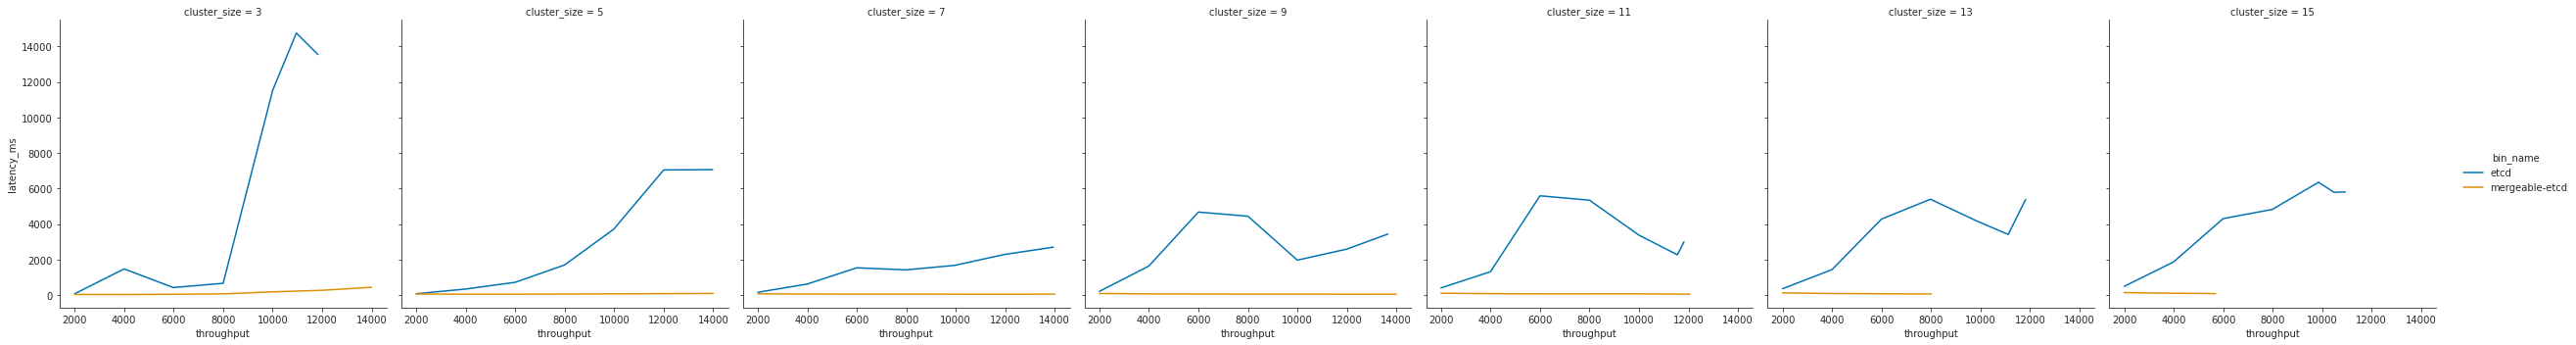

In [163]:
import seaborn as sns

sns.set_palette("colorblind")
sns.set_style("ticks")

# achieved throughput vs latency

data = final_df[final_df.cluster_size > 1]

med_latency = data.groupby(varied)["latency_ms"].median()

counts = data.groupby(varied)["start_relative"].count()
maxx = data.groupby(varied)["start_relative"].max() / 1000000000
data =  counts / maxx

data = pd.DataFrame(data)

data["latency_ms"] = med_latency
data["throughput"] = data["start_relative"]

display(data)

ax = sns.relplot(kind="line", data=data, x="throughput", y="latency_ms", hue="bin_name", col="cluster_size")

ax.savefig(f"{plots_dir}/throughput-latency.png")
ax.savefig(f"{plots_dir}/throughput-latency.svg")
ax.savefig(f"{plots_dir}/throughput-latency.pdf")

In [197]:
import seaborn as sns

sns.set_palette("colorblind")
sns.set_style("ticks")

# achieved throughput vs latency

data = final_df[final_df.cluster_size > 1]

med_latency = data.groupby(varied)["latency_ms"].median()

counts = data.groupby(varied)["start_relative"].count()
maxx = data.groupby(varied)["start_relative"].max() / 1000000000
data =  counts / maxx

data = pd.DataFrame(data)

data["latency_ms"] = med_latency
data["achieved_throughput"] = data["start_relative"]

display(data)

ax = sns.relplot(kind="line", data=data, x="target_throughput", y="achieved_throughput", hue="bin_name", col="cluster_size")

ax.savefig(f"{plots_dir}/throughput-throughput.png")
ax.savefig(f"{plots_dir}/throughput-throughput.svg")
ax.savefig(f"{plots_dir}/throughput-throughput.pdf")

KeyError: 'Column not found: latency_ms'

In [198]:
# stats

import pandas as pd

results_file = f"{exp_dir}/bencher-stats.csv"
stats_df = pd.read_csv(results_file)

stats_df.describe()

,num_procs,pids_stats_current,pids_stats_limit,network_rx_dropped,network_rx_bytes,network_rx_errors,network_rx_packets,network_tx_packets,network_tx_dropped,network_tx_errors,...,storage_stats_read_count_normalized,storage_stats_read_size_bytes,storage_stats_write_count_normalized,storage_stats_write_size_bytes,repeat,cluster_size,target_throughput,delay,delay_variation,node
count,34395.0,34395.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,34395.0,34395.000000,34395.000000,34395.0,3.439500e+04,34395.000000
mean,0.0,21.784562,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,11.257537,7126.675389,0.0,1.000000e-01,5.461782
std,0.0,14.009803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,3.429969,4133.926604,0.0,1.387799e-17,3.594926
min,0.0,7.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,3.000000,2000.000000,0.0,1.000000e-01,1.000000
25%,0.0,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,9.000000,4000.000000,0.0,1.000000e-01,2.000000
50%,0.0,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,11.000000,6000.000000,0.0,1.000000e-01,5.000000
75%,0.0,37.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,15.000000,10000.000000,0.0,1.000000e-01,8.000000
max,0.0,47.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,15.000000,14000.000000,0.0,1.000000e-01,15.000000


In [167]:
stats_df.head()

,read,preread,num_procs,pids_stats_current,pids_stats_limit,network_rx_dropped,network_rx_bytes,network_rx_errors,network_rx_packets,network_tx_packets,...,name,id,repeat,cluster_size,bench_type,target_throughput,bin_name,delay,delay_variation,node
0,2022-05-09T10:54:21.770932107Z,0001-01-01T00:00:00Z,0,8,NaN,NaN,NaN,NaN,NaN,NaN,...,/apj39-bencher-exp-node1,925f5a3f3d68284beb0bf5102dc61cedddace44acd9271...,0,3,PutRange,2000,etcd,0,0.1,1
1,2022-05-09T10:54:22.776152815Z,2022-05-09T10:54:21.770932107Z,0,9,NaN,NaN,NaN,NaN,NaN,NaN,...,/apj39-bencher-exp-node1,925f5a3f3d68284beb0bf5102dc61cedddace44acd9271...,0,3,PutRange,2000,etcd,0,0.1,1
2,2022-05-09T10:54:23.781504074Z,2022-05-09T10:54:22.776152815Z,0,27,NaN,NaN,NaN,NaN,NaN,NaN,...,/apj39-bencher-exp-node1,925f5a3f3d68284beb0bf5102dc61cedddace44acd9271...,0,3,PutRange,2000,etcd,0,0.1,1
3,2022-05-09T10:54:24.786824514Z,2022-05-09T10:54:23.781504074Z,0,27,NaN,NaN,NaN,NaN,NaN,NaN,...,/apj39-bencher-exp-node1,925f5a3f3d68284beb0bf5102dc61cedddace44acd9271...,0,3,PutRange,2000,etcd,0,0.1,1
4,2022-05-09T10:54:25.802434566Z,2022-05-09T10:54:24.786824514Z,0,28,NaN,NaN,NaN,NaN,NaN,NaN,...,/apj39-bencher-exp-node1,925f5a3f3d68284beb0bf5102dc61cedddace44acd9271...,0,3,PutRange,2000,etcd,0,0.1,1


In [172]:
list(stats_df.columns)

['read',
 'preread',
 'num_procs',
 'pids_stats_current',
 'pids_stats_limit',
 'network_rx_dropped',
 'network_rx_bytes',
 'network_rx_errors',
 'network_rx_packets',
 'network_tx_packets',
 'network_tx_dropped',
 'network_tx_errors',
 'network_tx_bytes',
 'networks_name',
 'networks_rx_dropped',
 'networks_rx_bytes',
 'networks_rx_errors',
 'networks_rx_packets',
 'networks_tx_packets',
 'networks_tx_dropped',
 'networks_tx_errors',
 'networks_tx_bytes',
 'memory_stats_stats_v1_cache',
 'memory_stats_stats_v1_dirty',
 'memory_stats_stats_v1_mapped_file',
 'memory_stats_stats_v1_total_inactive_file',
 'memory_stats_stats_v1_pgpgout',
 'memory_stats_stats_v1_rss',
 'memory_stats_stats_v1_total_mapped_file',
 'memory_stats_stats_v1_writeback',
 'memory_stats_stats_v1_unevictable',
 'memory_stats_stats_v1_pgpgin',
 'memory_stats_stats_v1_total_unevictable',
 'memory_stats_stats_v1_pgmajfault',
 'memory_stats_stats_v1_total_rss',
 'memory_stats_stats_v1_total_rss_huge',
 'memory_stats_sta

In [206]:
import datetime

def rfc3339_to_timestamp_ns(r):
    r = r[:26]
    dt = datetime.datetime.strptime(r, '%Y-%m-%dT%H:%M:%S.%f')
    timestamp = (dt - datetime.datetime(1970, 1, 1)) / timedelta(seconds=1)
    return timestamp
    
stats_df["start_s"] = stats_df.read.apply(rfc3339_to_timestamp_ns)

In [215]:
data = stats_df

min_data = data.groupby(varied)["start_s"].min()
min_data = min_data.rename("min_start")
display(min_data)

data = data.merge(min_data, on=varied, suffixes=(None, None))

data["start_relative"] = data["start_s"] - data["min_start"]
stats_df = data
stats_df

repeat  bench_type  bin_name        delay  cluster_size  target_throughput
0       PutRange    etcd            0      3             2000                 1.652094e+09
                                                         4000                 1.652094e+09
                                                         6000                 1.652094e+09
                                                         8000                 1.652094e+09
                                                         10000                1.652094e+09
                                                                                  ...     
                    mergeable-etcd  0      15            6000                 1.652103e+09
                                                         8000                 1.652103e+09
                                                         10000                1.652104e+09
                                                         12000                1.652104e+09
               

,read,preread,num_procs,pids_stats_current,pids_stats_limit,network_rx_dropped,network_rx_bytes,network_rx_errors,network_rx_packets,network_tx_packets,...,target_throughput,bin_name,delay,delay_variation,node,start,start_ns,start_s,min_start,start_relative
0,2022-05-09T10:54:21.770932107Z,0001-01-01T00:00:00Z,0,8,NaN,NaN,NaN,NaN,NaN,NaN,...,2000,etcd,0,0.1,1,1.652094e+09,1.652094e+09,1.652094e+09,1.652094e+09,0.000000
1,2022-05-09T10:54:22.776152815Z,2022-05-09T10:54:21.770932107Z,0,9,NaN,NaN,NaN,NaN,NaN,NaN,...,2000,etcd,0,0.1,1,1.652094e+09,1.652094e+09,1.652094e+09,1.652094e+09,1.005220
2,2022-05-09T10:54:23.781504074Z,2022-05-09T10:54:22.776152815Z,0,27,NaN,NaN,NaN,NaN,NaN,NaN,...,2000,etcd,0,0.1,1,1.652094e+09,1.652094e+09,1.652094e+09,1.652094e+09,2.010572
3,2022-05-09T10:54:24.786824514Z,2022-05-09T10:54:23.781504074Z,0,27,NaN,NaN,NaN,NaN,NaN,NaN,...,2000,etcd,0,0.1,1,1.652094e+09,1.652094e+09,1.652094e+09,1.652094e+09,3.015892
4,2022-05-09T10:54:25.802434566Z,2022-05-09T10:54:24.786824514Z,0,28,NaN,NaN,NaN,NaN,NaN,NaN,...,2000,etcd,0,0.1,1,1.652094e+09,1.652094e+09,1.652094e+09,1.652094e+09,4.031502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34390,2022-05-09T13:56:16.499143059Z,2022-05-09T13:56:15.454486020Z,0,9,NaN,NaN,NaN,NaN,NaN,NaN,...,14000,mergeable-etcd,0,0.1,15,1.652105e+09,1.652105e+09,1.652105e+09,1.652105e+09,52.676695
34391,2022-05-09T13:56:17.871624018Z,2022-05-09T13:56:16.499143059Z,0,9,NaN,NaN,NaN,NaN,NaN,NaN,...,14000,mergeable-etcd,0,0.1,15,1.652105e+09,1.652105e+09,1.652105e+09,1.652105e+09,54.049176
34392,2022-05-09T13:56:19.241738113Z,2022-05-09T13:56:17.871624018Z,0,9,NaN,NaN,NaN,NaN,NaN,NaN,...,14000,mergeable-etcd,0,0.1,15,1.652105e+09,1.652105e+09,1.652105e+09,1.652105e+09,55.419290
34393,2022-05-09T13:56:20.444443579Z,2022-05-09T13:56:19.241738113Z,0,9,NaN,NaN,NaN,NaN,NaN,NaN,...,14000,mergeable-etcd,0,0.1,15,1.652105e+09,1.652105e+09,1.652105e+09,1.652105e+09,56.621995


In [235]:
import seaborn as sns

# cpu usage plots

def plot_cpu(cluster_size, bench_type):
    data = stats_df
    data = data[data.cluster_size == cluster_size]
    data = data[data.bench_type == bench_type]

    data["cpu_usage"] = data["cpu_stats_cpu_usage_total_usage"].diff()
    data = data[data.cpu_usage >= 0]

    sns.relplot(kind="line", data=data, x="start_relative", y="cpu_usage", hue="bin_name", col="node", row="target_throughput")

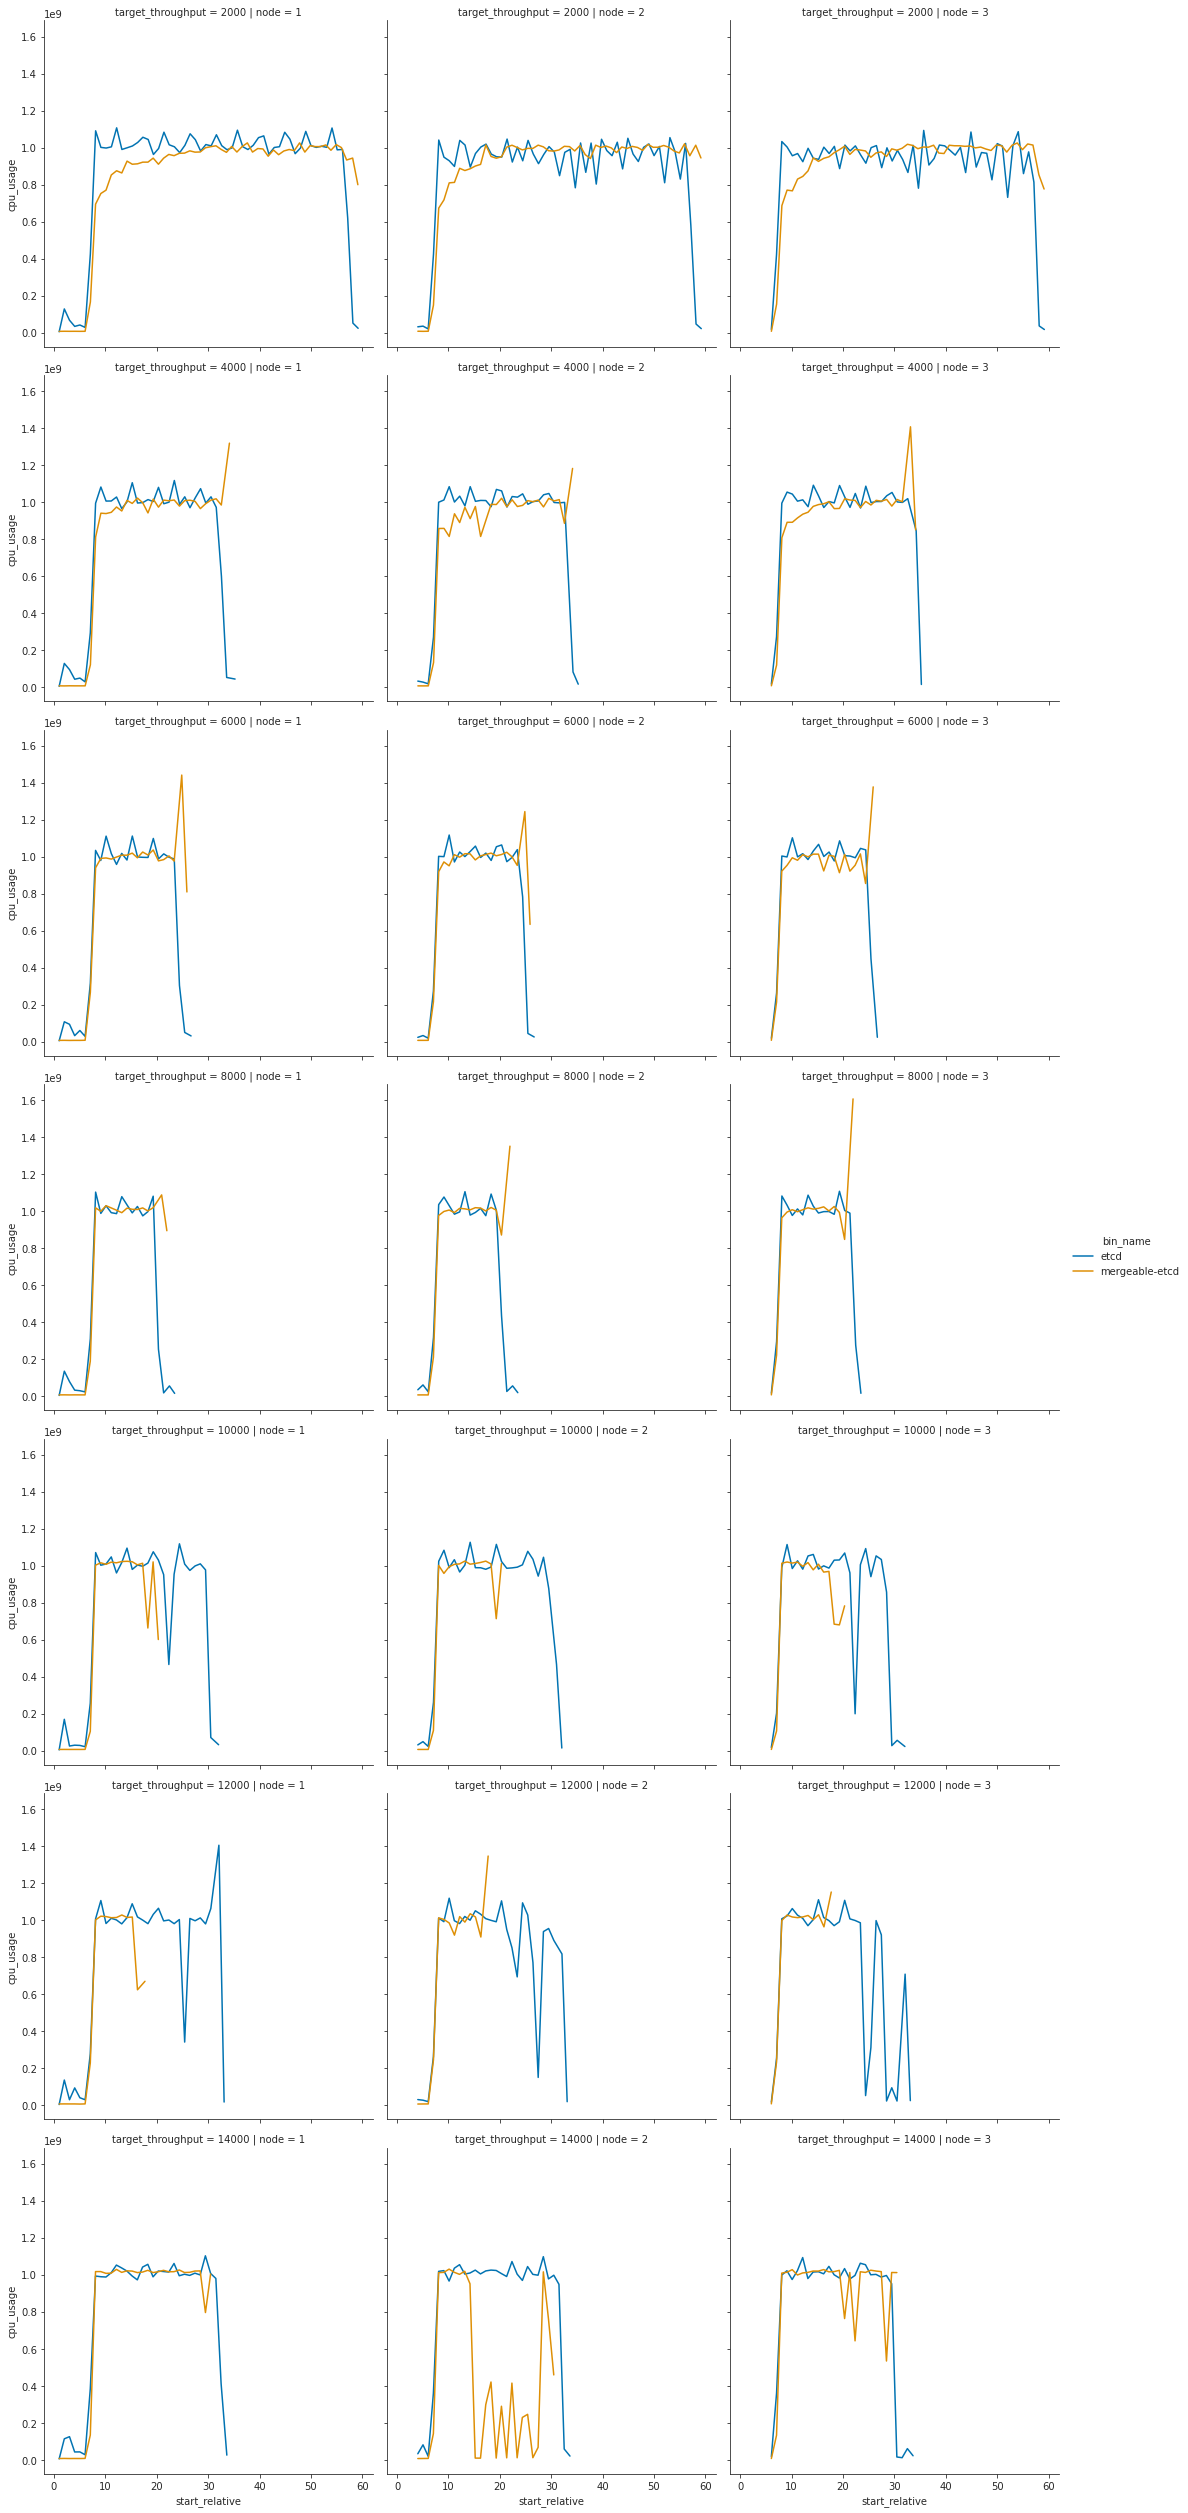

In [237]:
plot_cpu(3, "PutRange")

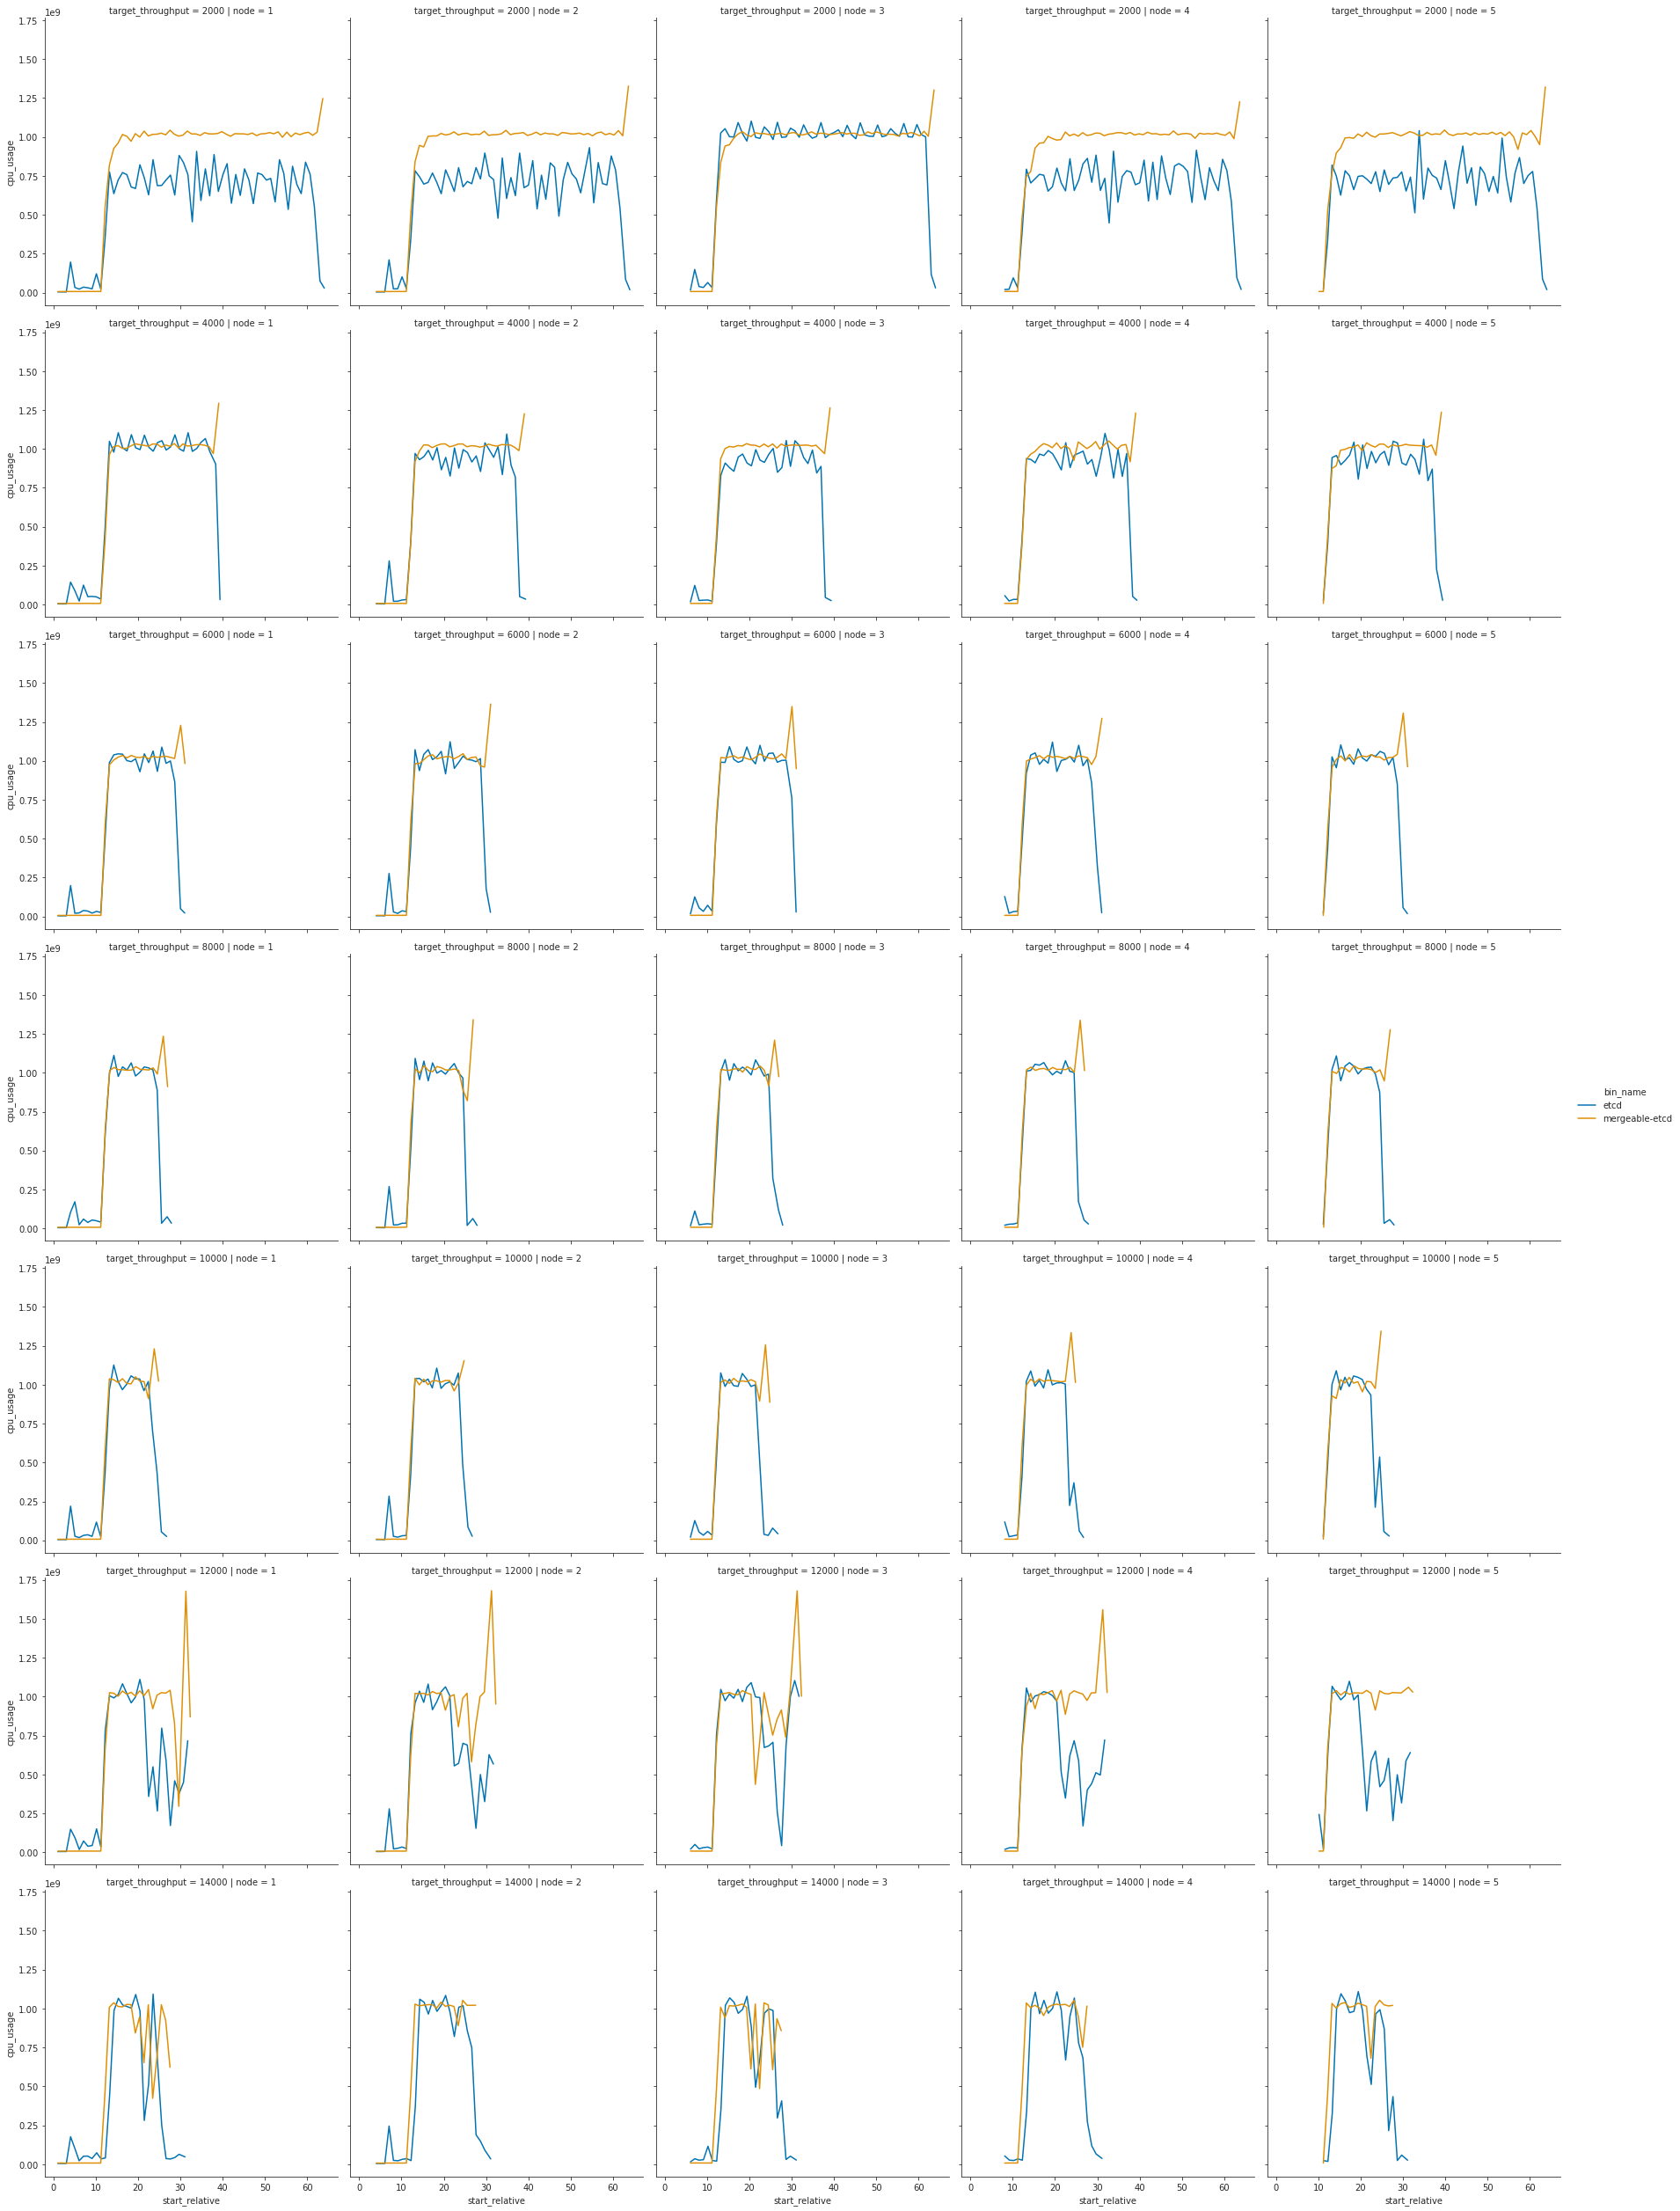

In [238]:
plot_cpu(5, "PutRange")

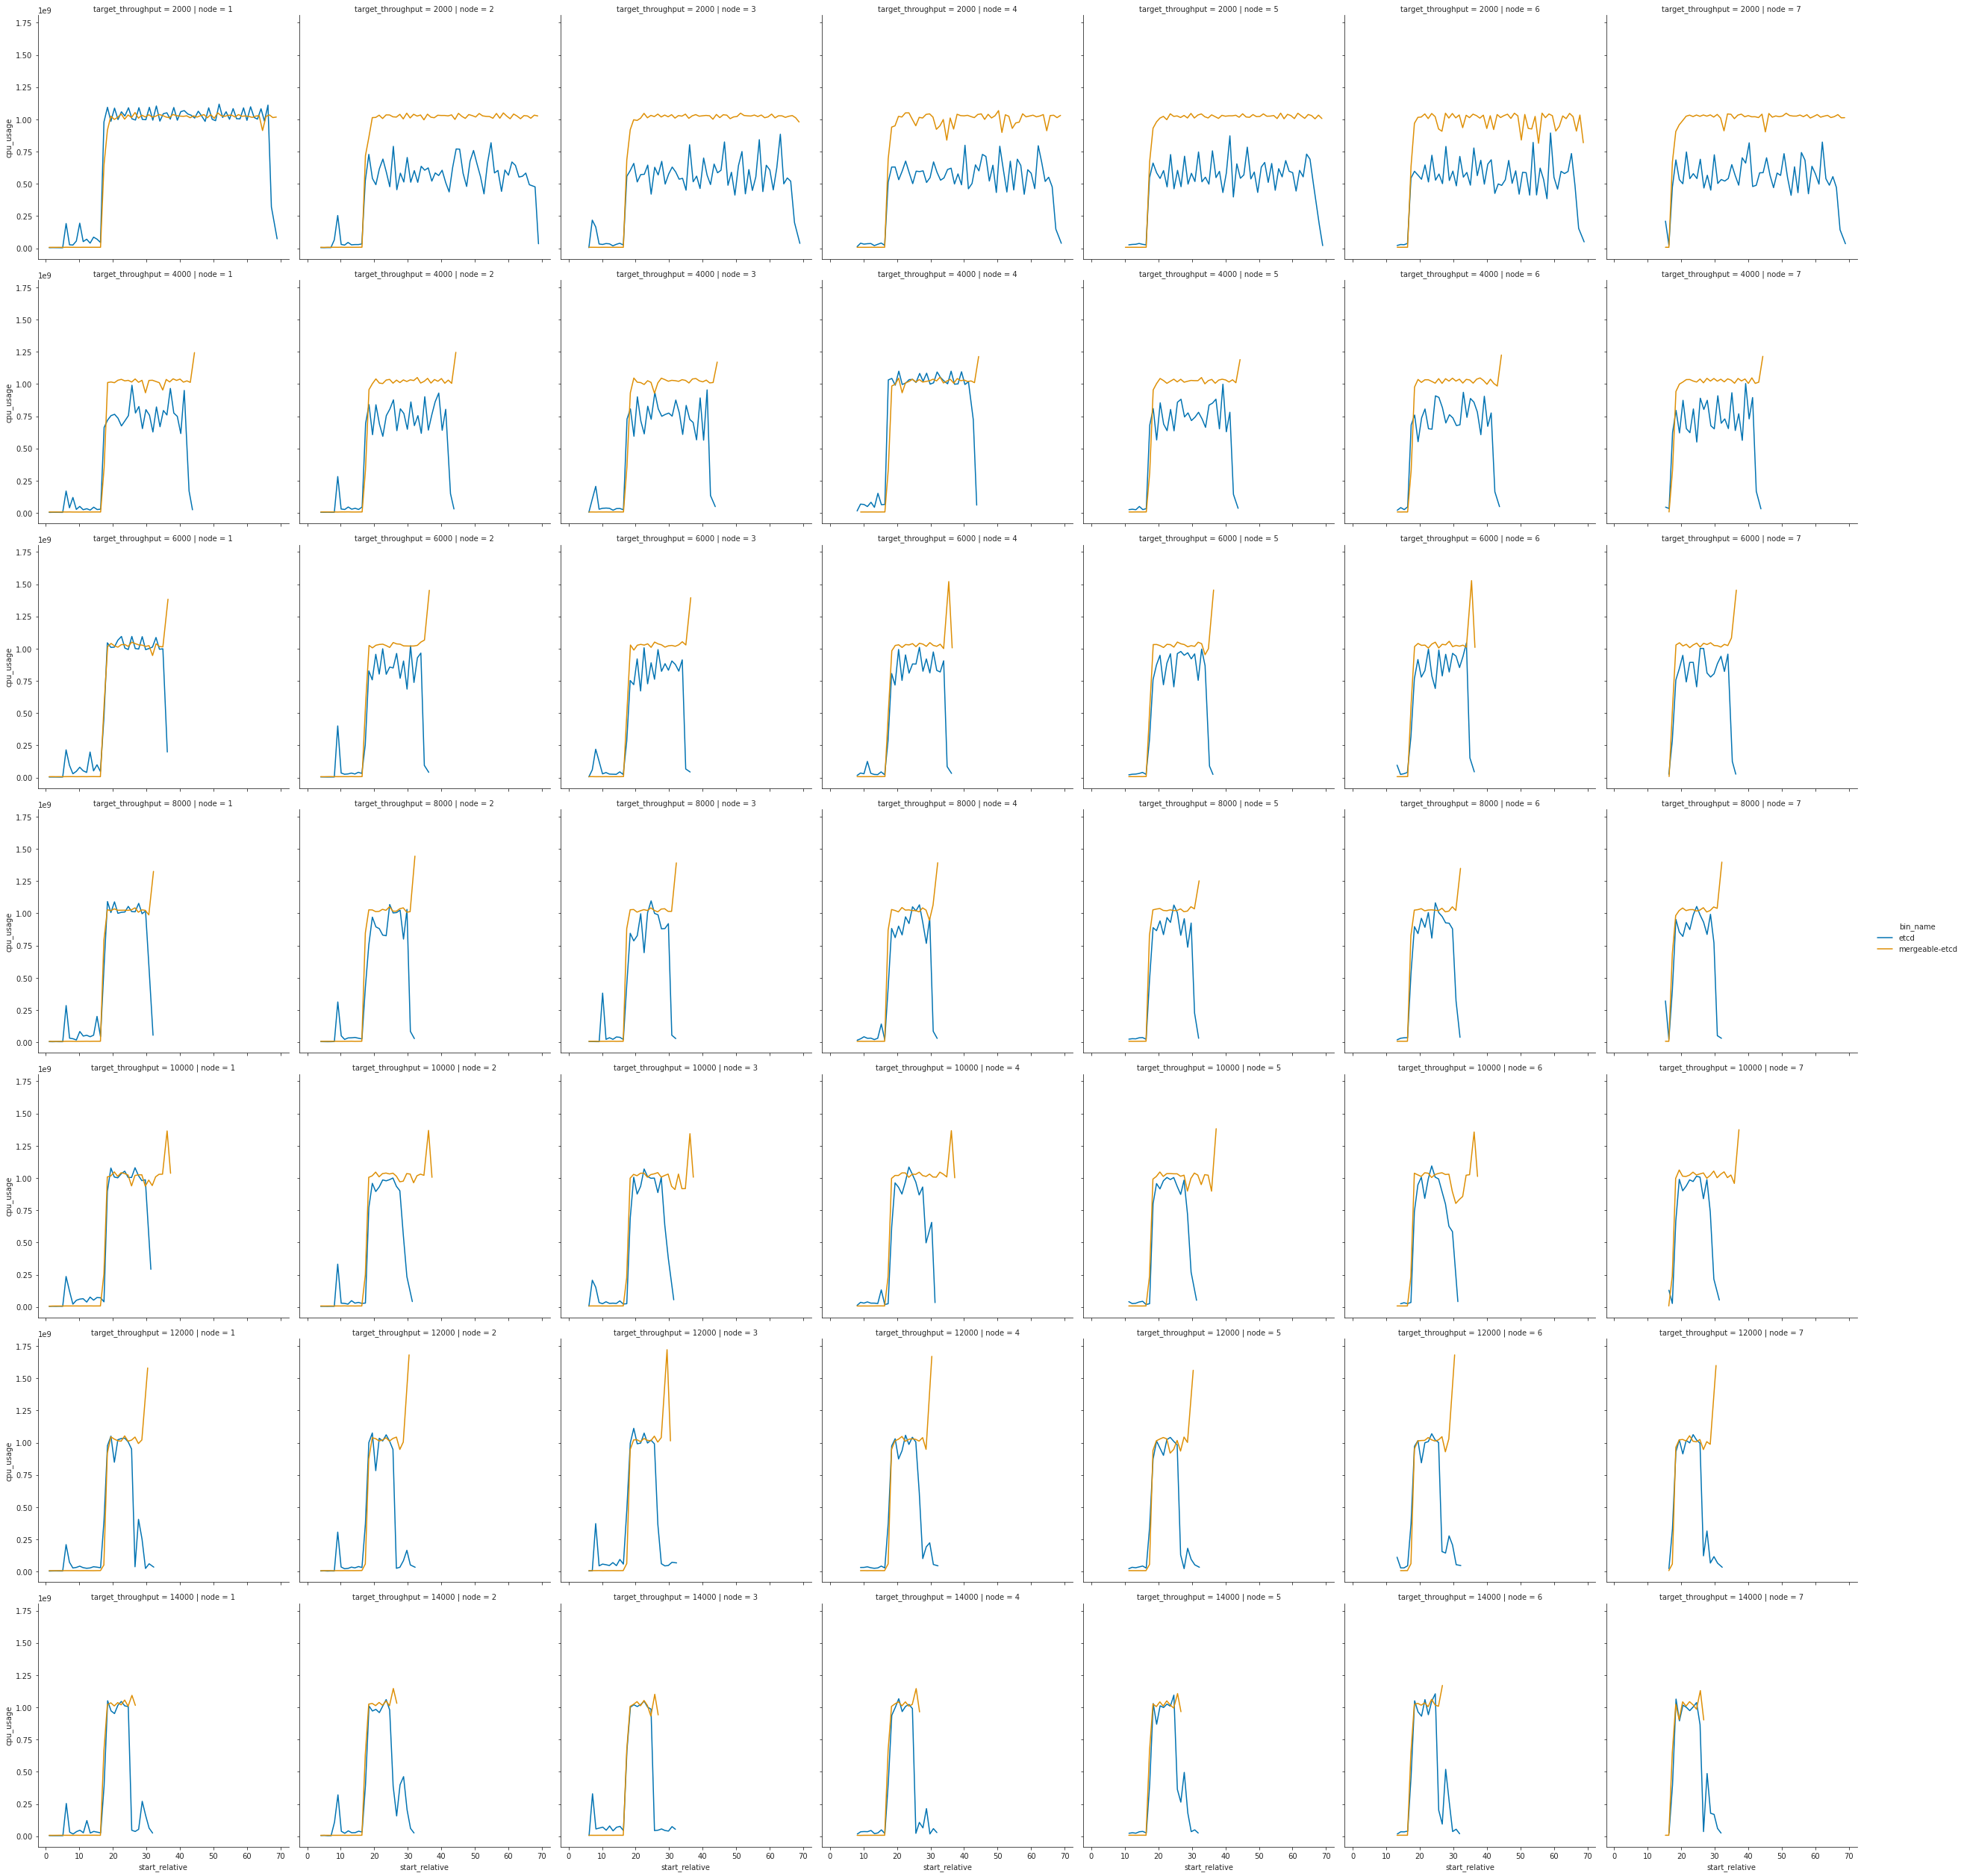

In [239]:
plot_cpu(7, "PutRange")

In [240]:
import seaborn as sns

# memory usage

def plot_mem(cluster_size, bench_type):
    data = stats_df

    data = data[data.cluster_size == cluster_size]
    data = data[data.bench_type == bench_type]

    sns.relplot(kind="line", data=data, x="start_relative", y="memory_stats_usage", hue="bin_name", col="node", row="target_throughput")

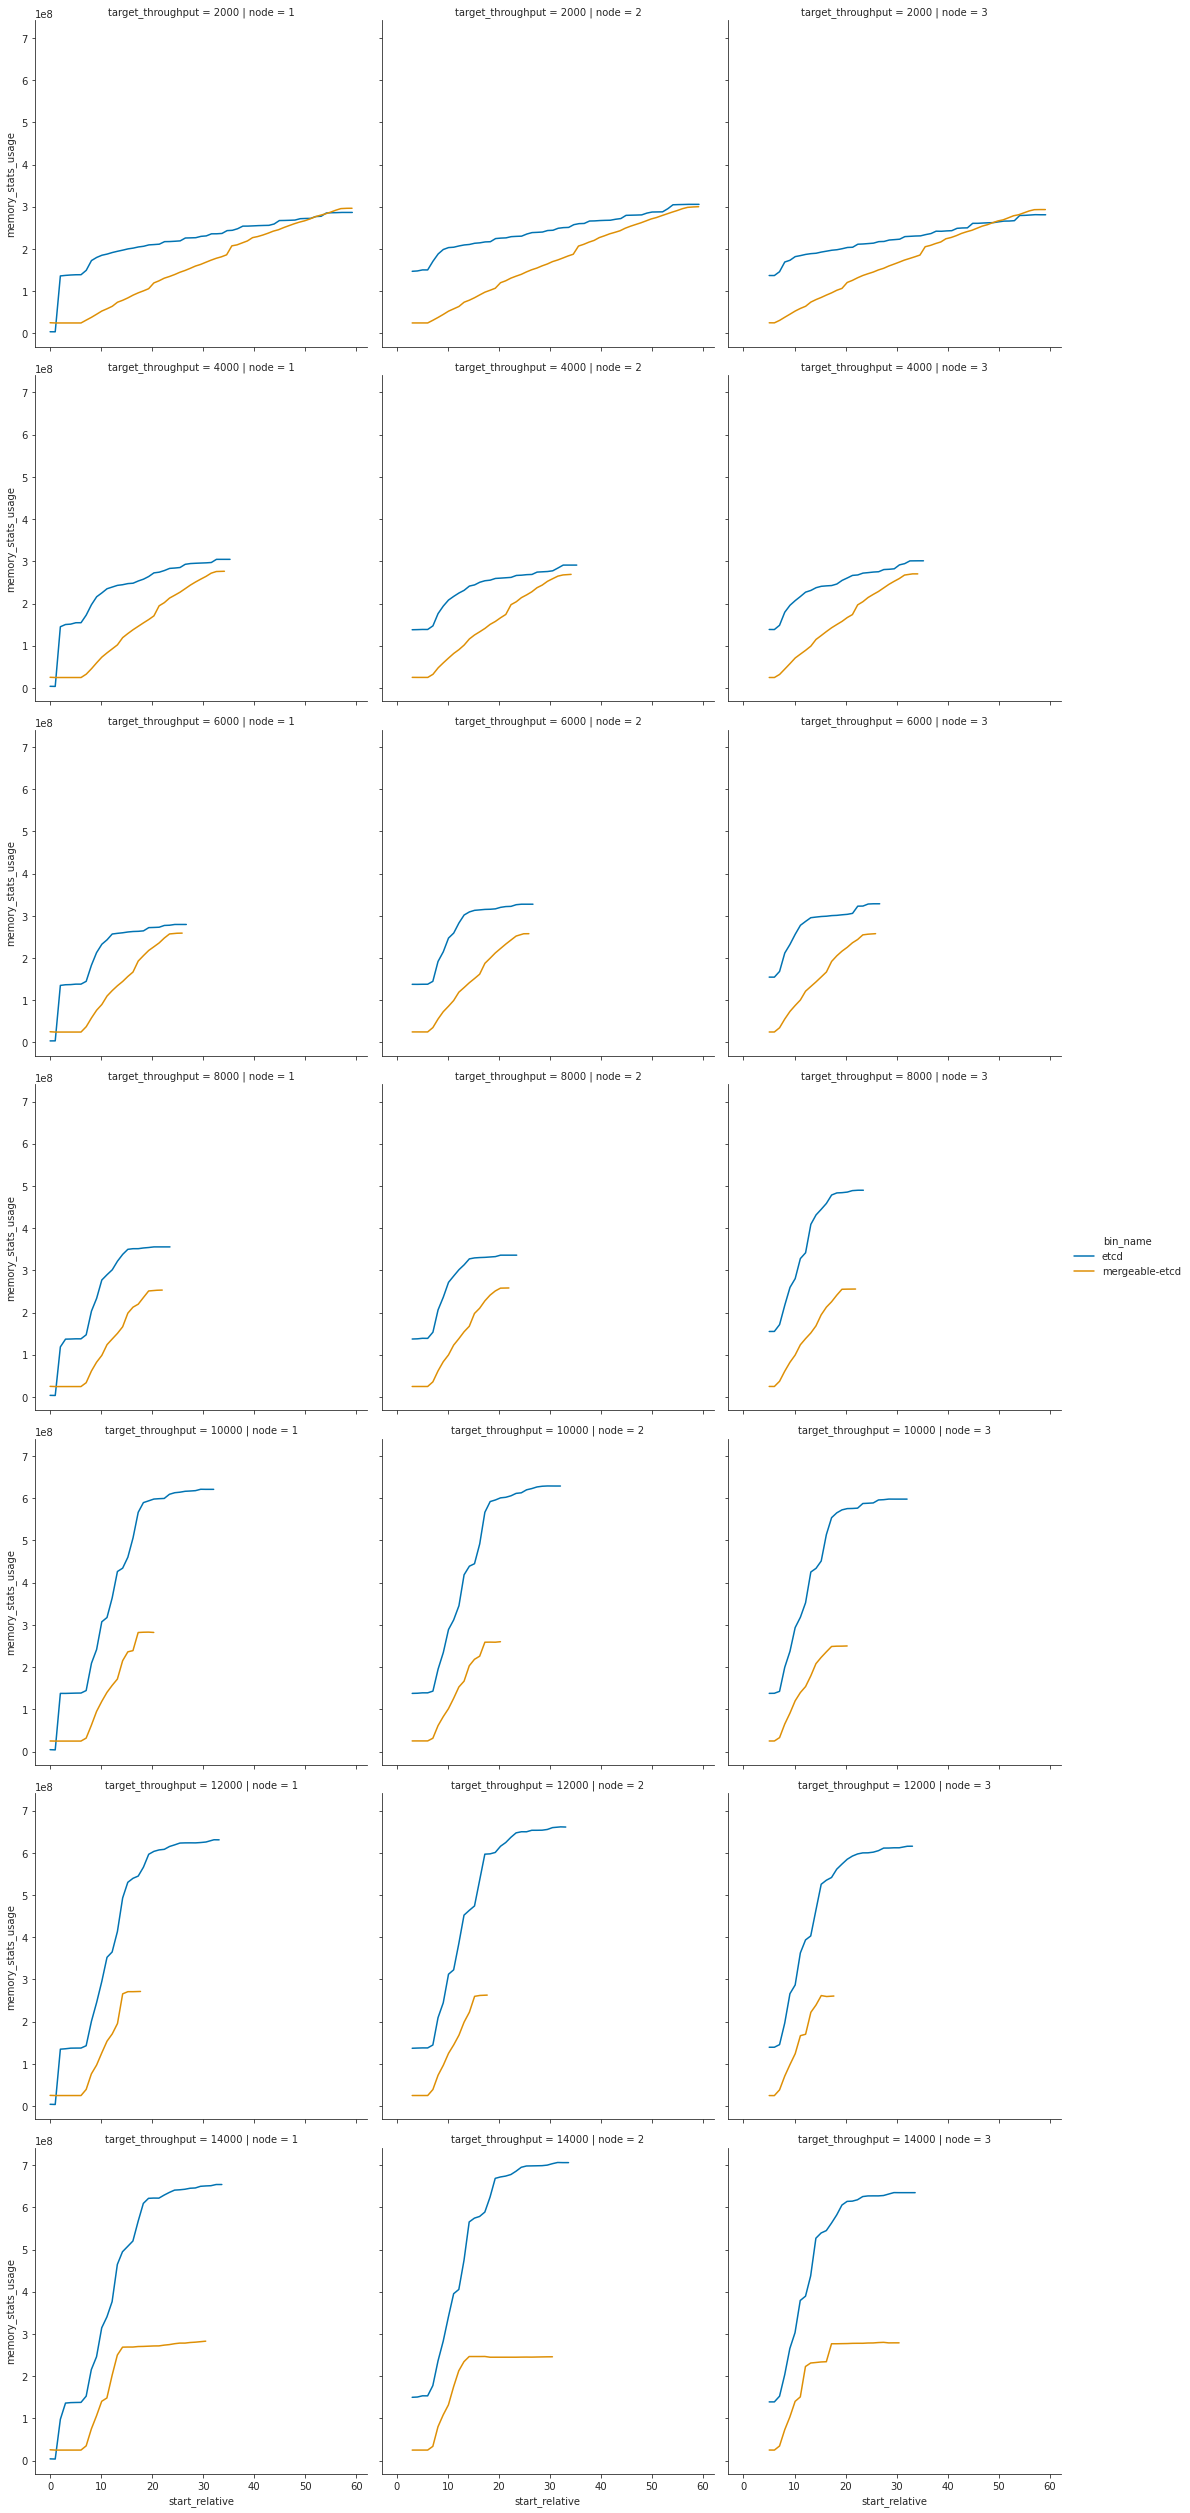

In [241]:
plot_mem(3, "PutRange")

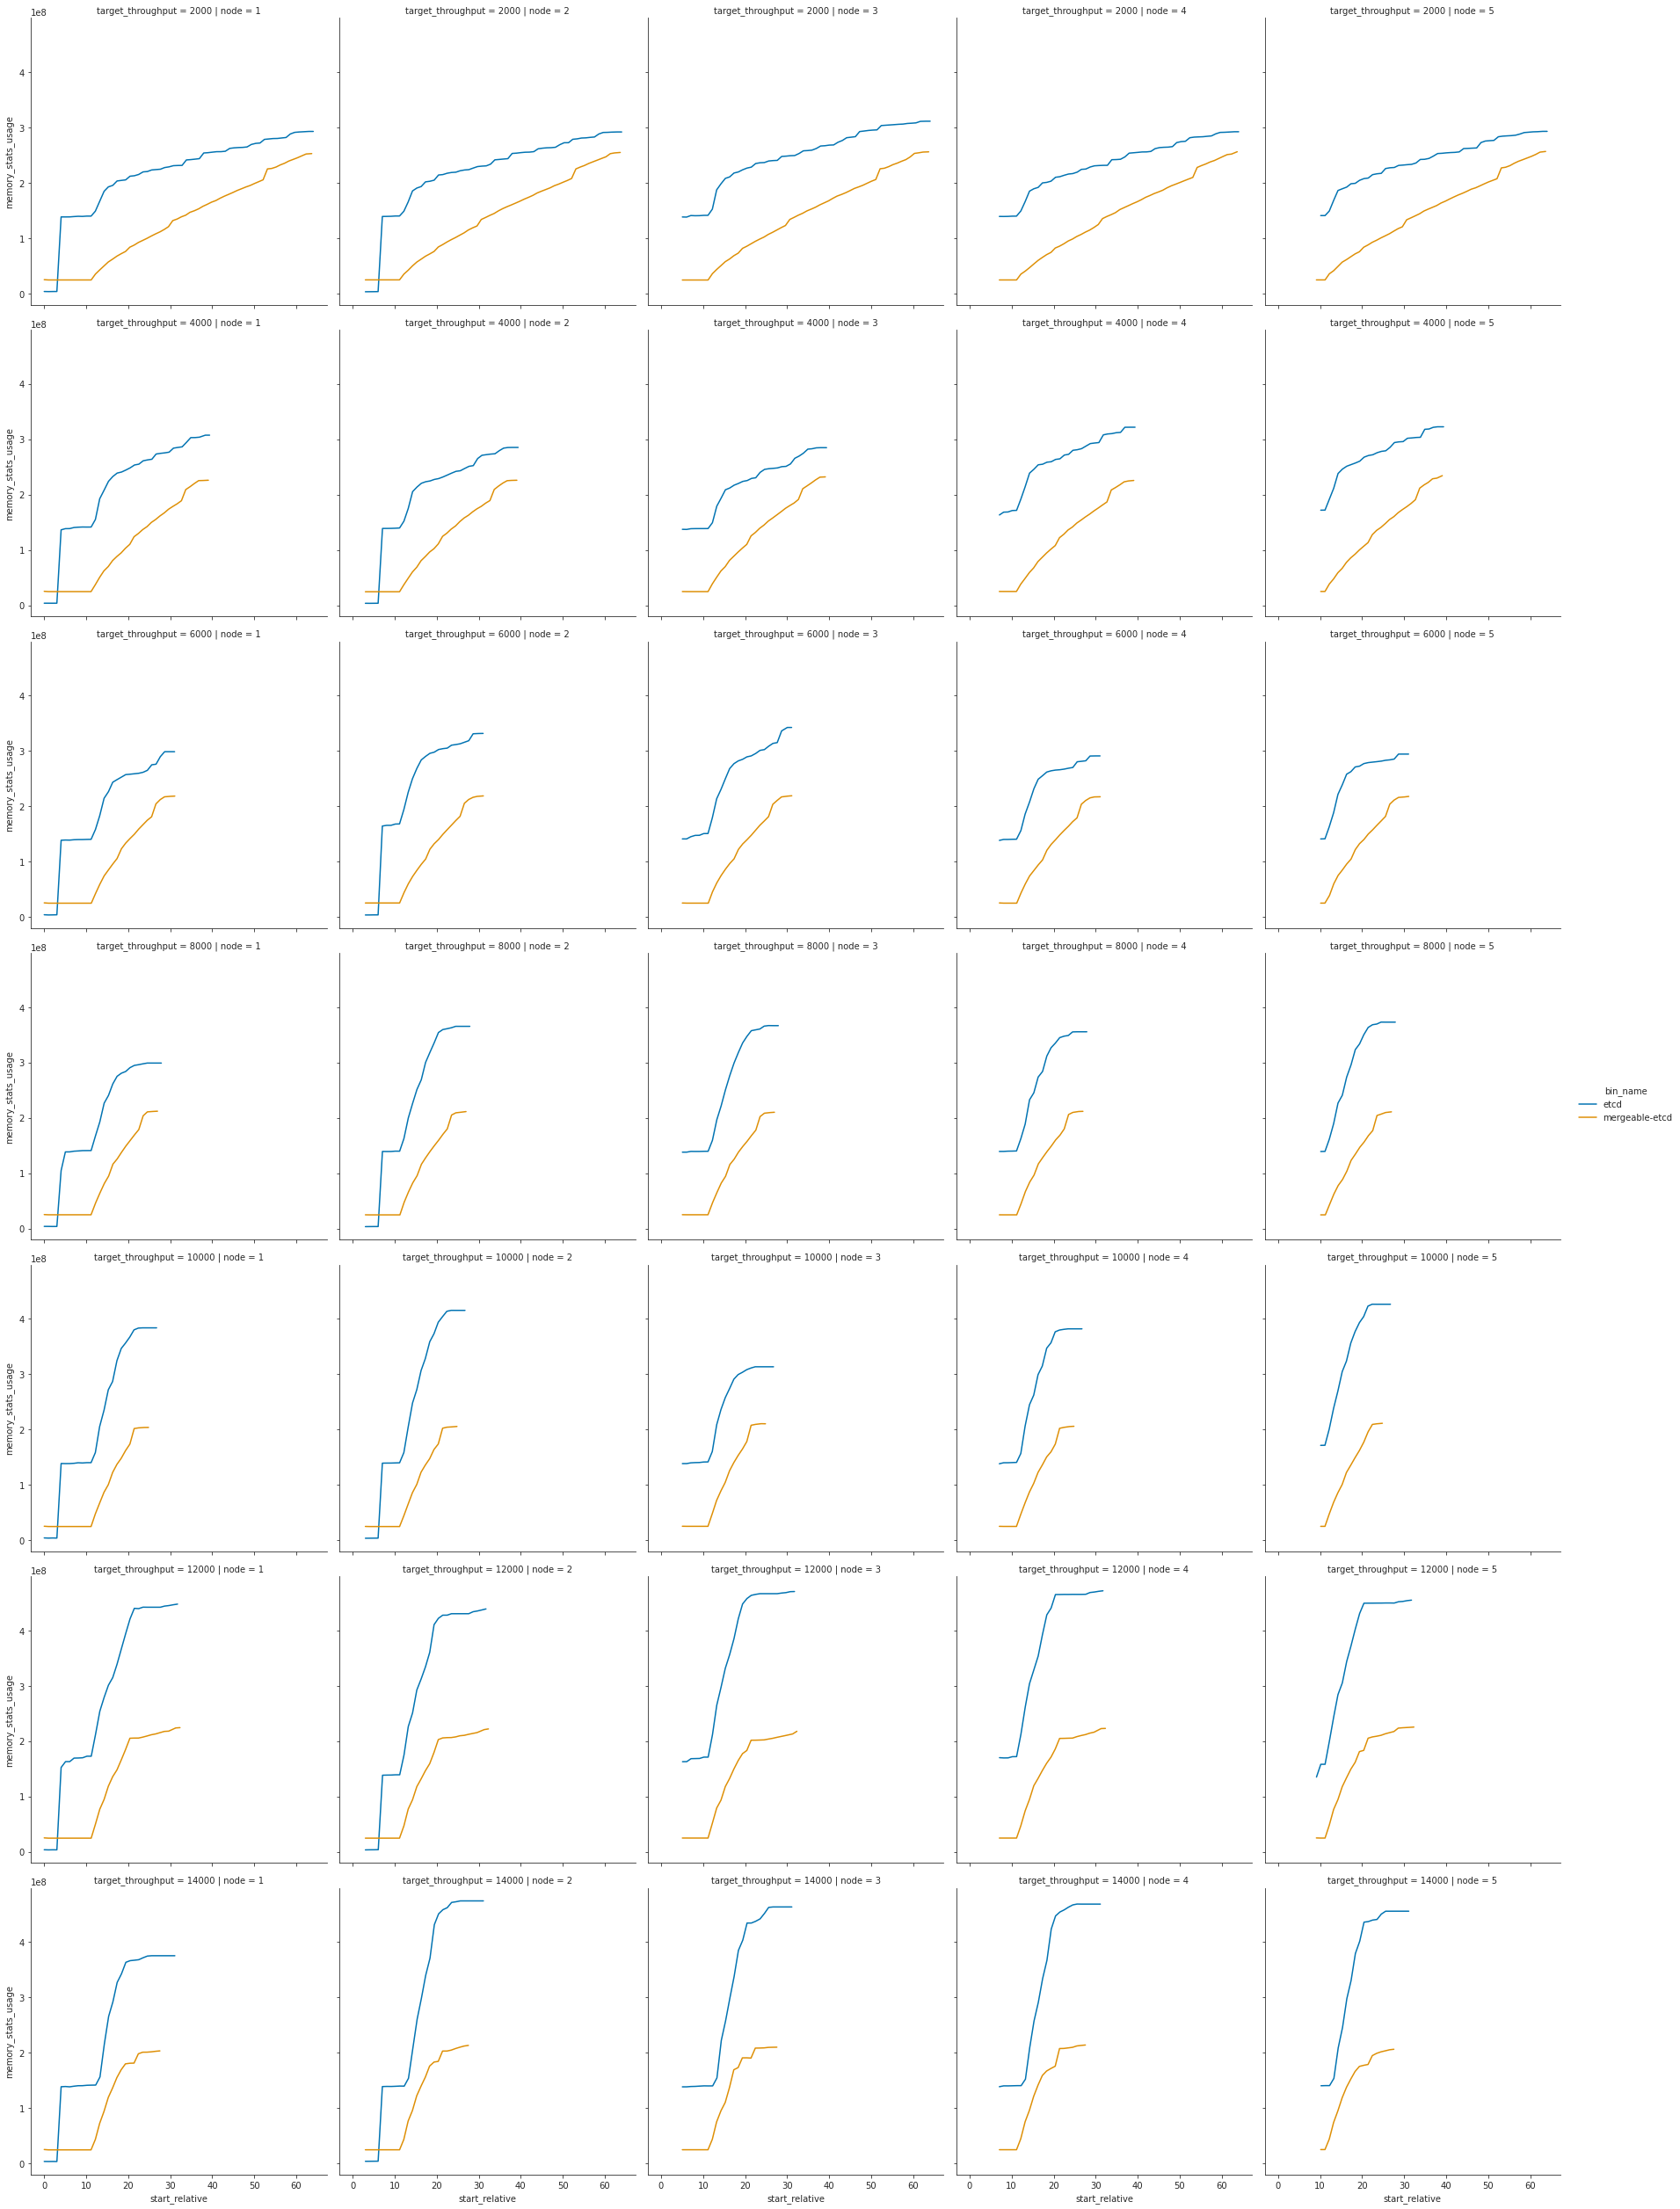

In [242]:
plot_mem(5, "PutRange")

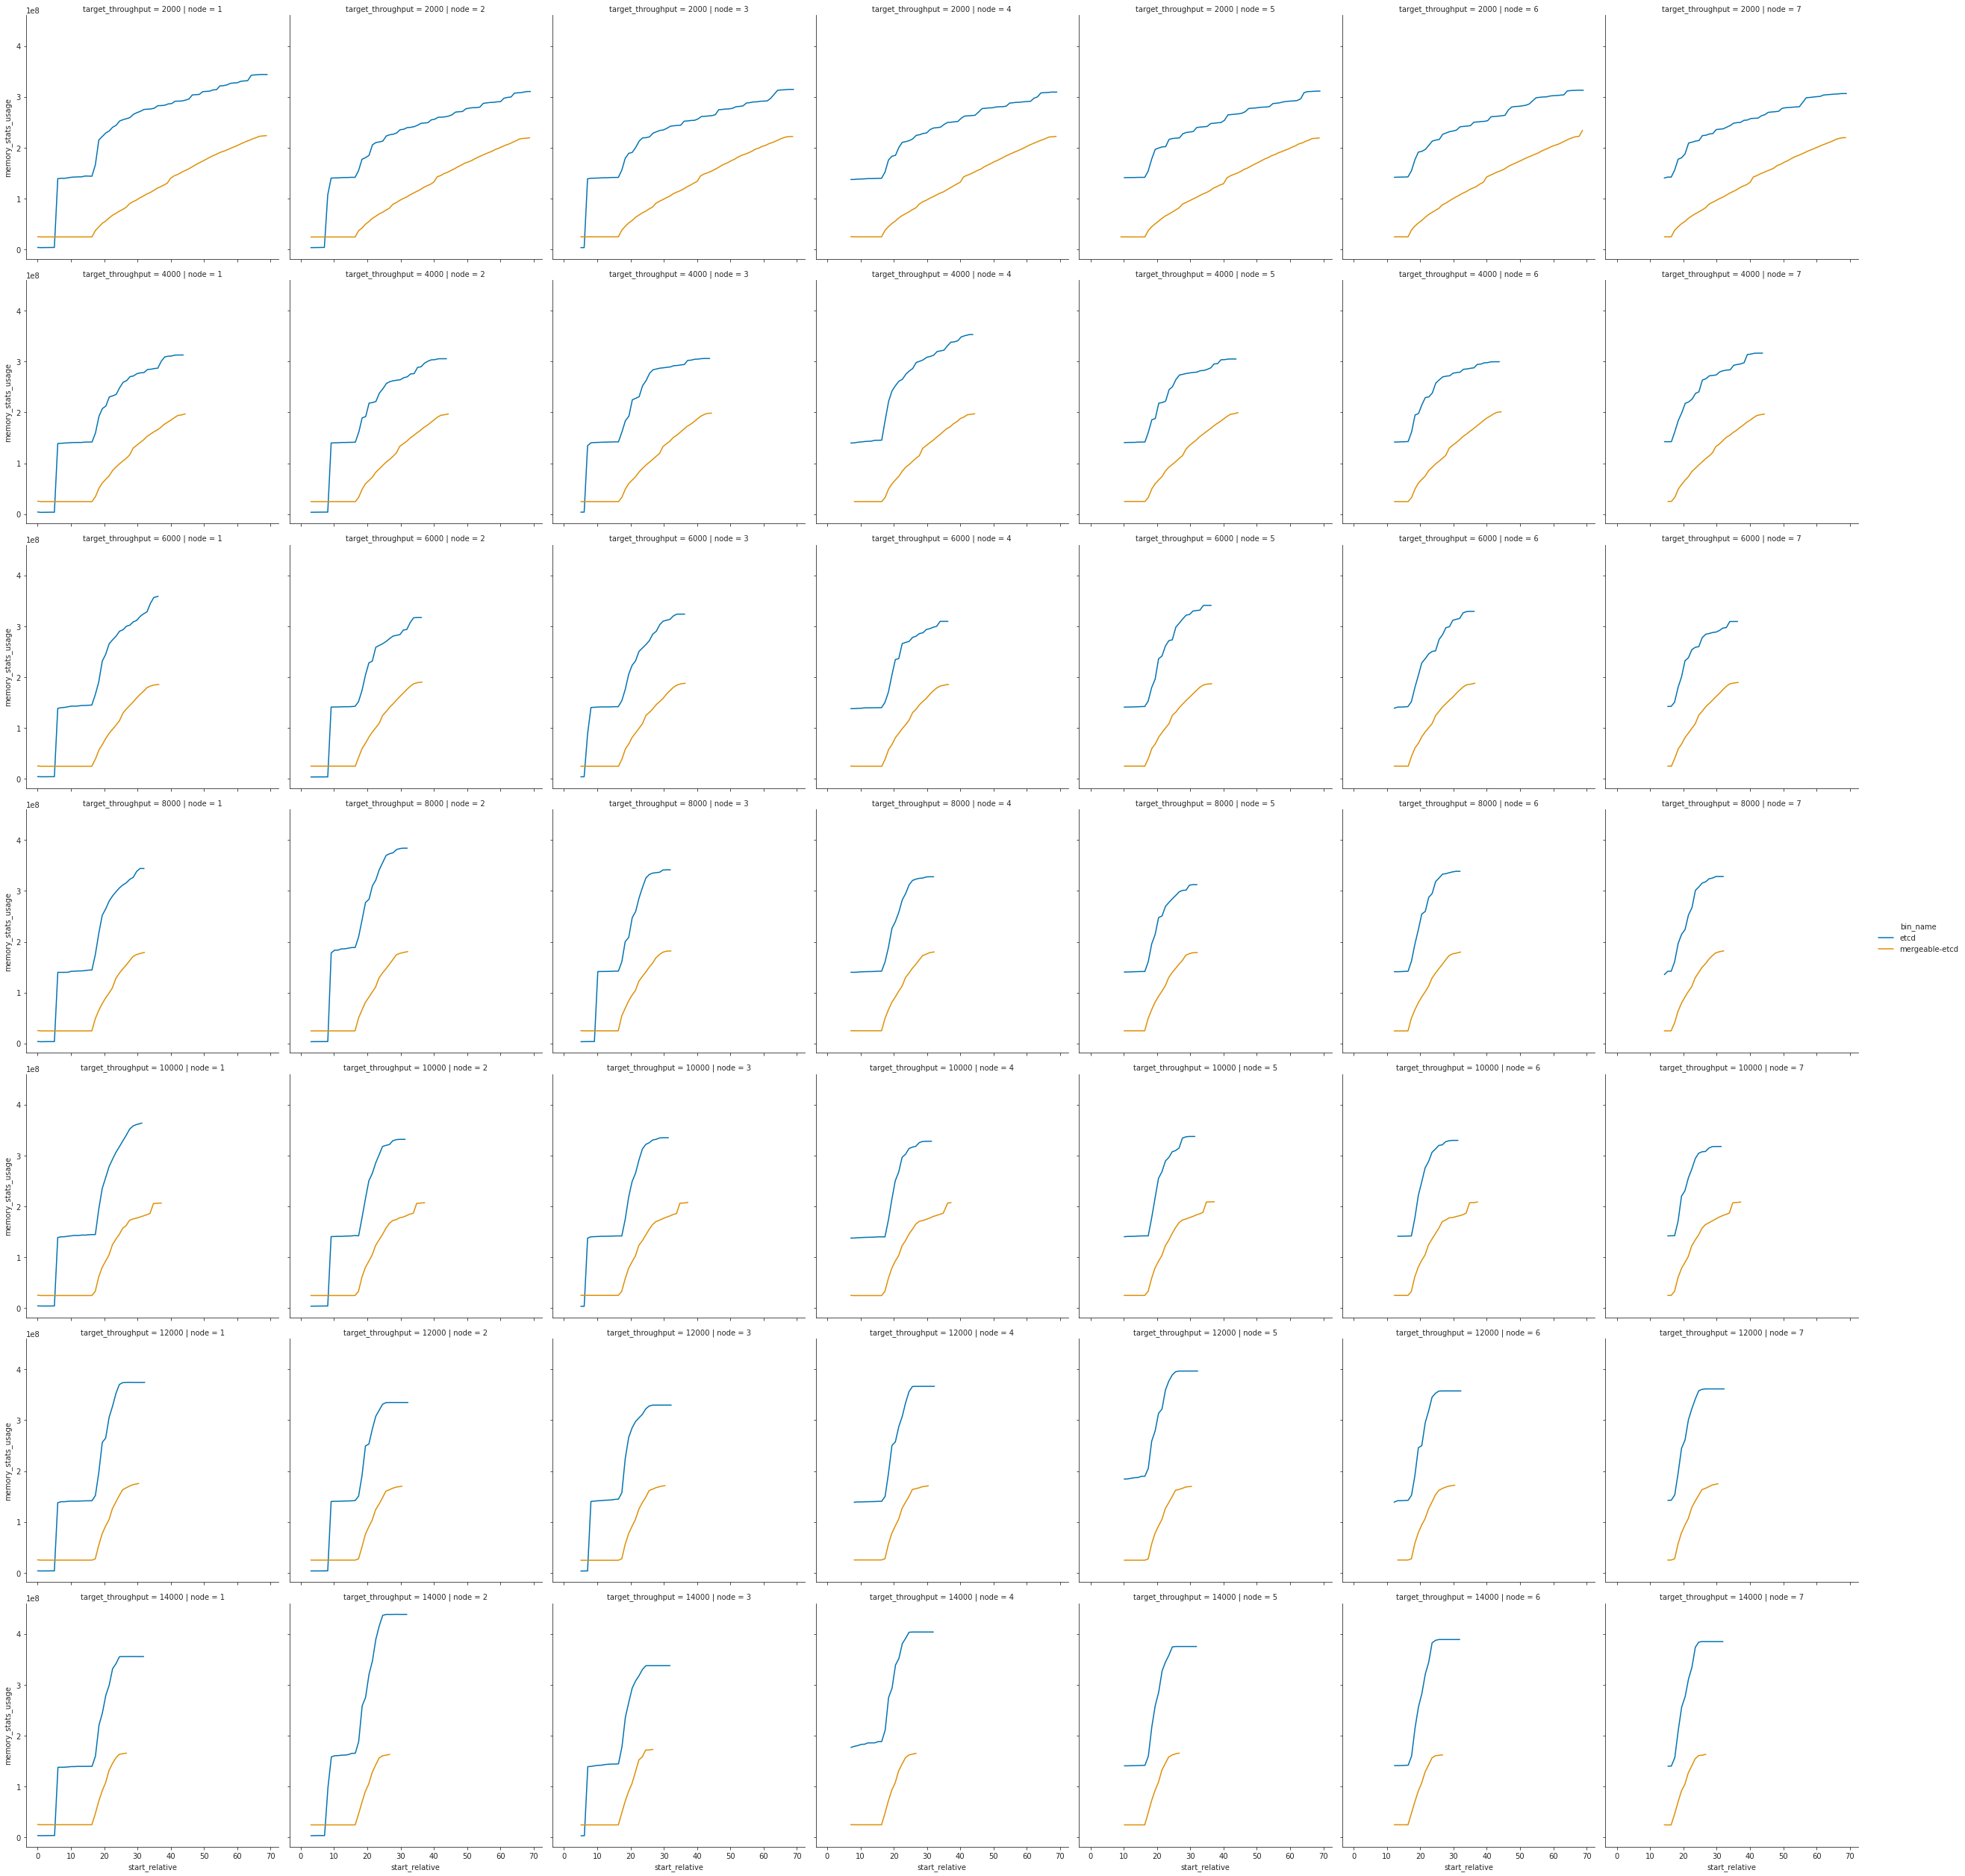

In [243]:
plot_mem(7, "PutRange")